In [1]:
import os
import json
import warnings
import pickle
import joblib
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb


from matplotlib.colors import LinearSegmentedColormap
from typing import Tuple, Dict, List, Any, Optional
from sklearn.preprocessing import StandardScaler
from scipy import stats
from IPython.display import display, Markdown
from datetime import timedelta
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor


# Optional: for interactive visualization
try:
    from pyvis.network import Network
    PYVIS_AVAILABLE = True
except ImportError:
    PYVIS_AVAILABLE = False
    print("Warning: pyvis not installed. Interactive visualization will be skipped.")


warnings.filterwarnings('ignore')

c:\Users\Iman\OneDrive\Desktop\knowledge_graph_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br> <br>

## Loading the Dataset

In [2]:
# Load X (features) files
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")

# Load y (target) files
y_train = pd.read_csv("../data/processed/y_train.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Combine X and y for train set
df_train = X_train.copy()
df_train['Sales'] = y_train.values  # Assuming y_train has Sales column or is a single column

# Combine X and y for test set
df_test = X_test.copy()
df_test['Sales'] = y_test.values  # Assuming y_test has Sales column or is a single column

print(f"\ndf_train shape: {df_train.shape}")
print(f"df_test shape: {df_test.shape}")

# Check if Date column exists for temporal ordering
if 'Date' in df_train.columns:
    # Ensure Date is datetime format
    df_train['Date'] = pd.to_datetime(df_train['Date'])
    df_test['Date'] = pd.to_datetime(df_test['Date'])
    
    # Concatenate train and test datasets
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    
    # Sort by Date to maintain temporal sequence
    df_combined = df_combined.sort_values('Date').reset_index(drop=True)
    
    print(f"\nCombined dataset shape: {df_combined.shape}")
    print(f"Date range: {df_combined['Date'].min()} to {df_combined['Date'].max()}")
else:
    # If no Date column, just concatenate (assuming data is already in order)
    df_combined = pd.concat([df_train, df_test], ignore_index=True)
    print(f"\nCombined dataset shape: {df_combined.shape}")
    print("⚠️  Warning: No Date column found. Temporal order may not be guaranteed.")

print(f"Number of records: {len(df_combined):,}")

# Display first and last few rows to verify
display(df_combined.head(3))


X_train shape: (7831, 199)
X_test shape: (1230, 199)
y_train shape: (7831, 1)
y_test shape: (1230, 1)

df_train shape: (7831, 200)
df_test shape: (1230, 200)

Combined dataset shape: (9061, 200)
Date range: 2023-01-01 00:00:00 to 2023-08-09 00:00:00
Number of records: 9,061


,Date,Production,Factory_Issue,Delivery,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,...,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban centres (esp. Dhaka),scope_or_location_nan,Sales
0,2023-01-01,0.079538,0.049447,0.038181,0.0,0.380952,0.777778,0.222222,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2642.0
1,2023-01-01,0.000000,0.000000,0.000000,0.0,0.380952,0.777778,0.222222,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-01-01,0.000000,0.000000,0.000000,0.0,0.380952,0.777778,0.222222,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


<br> <br> <br>

## Creating the Causal Graph

In [3]:
class TimeSeriesCausalDiscovery:
    """
    A robust causal discovery class for time series data.
    
    This class combines:
    1. PC algorithm for constraint-based structure learning
    2. Granger causality for temporal relationship orientation
    3. Correlation analysis for edge strength
    
    All features from the input dataset are guaranteed to appear in the output
    causal graph, even if they have no detected causal relationships.
    
    Parameters:
    -----------
    alpha : float
        Significance level for conditional independence tests (default: 0.05)
    correlation_threshold : float
        Minimum correlation to consider as potential edge (default: 0.1)
    max_lag : int
        Maximum lag for Granger causality analysis (default: 1)
    
    Attributes:
    -----------
    feature_names : List[str]
        List of all feature names in the order they appear
    edges : List[Dict]
        List of discovered causal edges
    nodes : List[Dict]
        List of all nodes (features) in the graph
    adjacency_matrix : np.ndarray
        Adjacency matrix representing the causal structure
    """
    
    def __init__(self, 
                 alpha: float = 0.05,
                 correlation_threshold: float = 0.1,
                 max_lag: int = 1):
        self.alpha = alpha
        self.correlation_threshold = correlation_threshold
        self.max_lag = max_lag
        self.feature_names = None
        self.edges = []
        self.nodes = []
        self.adjacency_matrix = None
        self._variable_cols = []
        self._constant_cols = []
        
    def _preprocess_data(self, df: pd.DataFrame, 
                         date_col: str = 'Date',
                         target_col: str = 'Sales') -> Tuple[pd.DataFrame, List[str]]:
        """Preprocess the dataframe for causal discovery."""
        data = df.copy()
        
        # Remove index column if exists
        if 'Unnamed: 0' in data.columns:
            data = data.drop(columns=['Unnamed: 0'])
        
        # Handle date column
        if date_col in data.columns:
            data[date_col] = pd.to_datetime(data[date_col])
            data = data.sort_values(date_col)
            data = data.drop(columns=[date_col])
        
        # Store feature names (ensuring target is tracked)
        feature_names = list(data.columns)
        
        # Ensure target is at the end
        if target_col in feature_names:
            feature_names.remove(target_col)
            feature_names.append(target_col)
            data = data[feature_names]
        
        self.feature_names = feature_names
        
        # Handle missing and infinite values
        data = data.fillna(0)
        data = data.replace([np.inf, -np.inf], 0)
        
        return data, feature_names
    
    def _aggregate_by_date(self, df: pd.DataFrame, 
                           date_col: str = 'Date') -> pd.DataFrame:
        """Aggregate data by date for time series analysis."""
        data = df.copy()
        
        if 'Unnamed: 0' in data.columns:
            data = data.drop(columns=['Unnamed: 0'])
        
        if date_col in data.columns:
            numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
            agg_dict = {col: 'mean' for col in numeric_cols if col != date_col}
            data = data.groupby(date_col).agg(agg_dict).reset_index()
        
        return data
    
    def _remove_constant_columns(self, data: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
        """Remove constant columns but track them for the output."""
        constant_cols = []
        variable_cols = []
        
        for col in data.columns:
            if data[col].nunique() <= 1 or data[col].std() < 1e-10:
                constant_cols.append(col)
            else:
                variable_cols.append(col)
        
        return data[variable_cols], constant_cols
    
    def _compute_correlation_matrix(self, data: pd.DataFrame) -> pd.DataFrame:
        """Compute correlation matrix with handling for numerical issues."""
        try:
            corr_matrix = data.corr(method='spearman')
        except Exception:
            corr_matrix = data.corr(method='pearson')
        
        corr_matrix = corr_matrix.fillna(0)
        return corr_matrix
    
    def _compute_partial_correlation(self, data: pd.DataFrame, 
                                     x: str, y: str, 
                                     z: List[str]) -> Tuple[float, float]:
        """Compute partial correlation between x and y given z."""
        if len(z) == 0:
            r, p = stats.spearmanr(data[x], data[y])
            return r, p
        
        try:
            from sklearn.linear_model import Ridge
            
            X_z = data[z].values
            x_vals = data[x].values
            y_vals = data[y].values
            
            reg_x = Ridge(alpha=1.0)
            reg_x.fit(X_z, x_vals)
            resid_x = x_vals - reg_x.predict(X_z)
            
            reg_y = Ridge(alpha=1.0)
            reg_y.fit(X_z, y_vals)
            resid_y = y_vals - reg_y.predict(X_z)
            
            r, p = stats.spearmanr(resid_x, resid_y)
            return r, p
        except Exception:
            return 0.0, 1.0
    
    def _granger_causality_test(self, data: pd.DataFrame, 
                                cause: str, effect: str, 
                                max_lag: int = 1) -> Tuple[float, float]:
        """Simple Granger causality test."""
        try:
            from sklearn.linear_model import Ridge
            from scipy.stats import f as f_dist
            
            y = data[effect].values[max_lag:]
            
            X_restricted = np.column_stack([
                data[effect].shift(i).values[max_lag:] 
                for i in range(1, max_lag + 1)
            ])
            
            X_unrestricted = np.column_stack([
                X_restricted,
                *[data[cause].shift(i).values[max_lag:] 
                  for i in range(1, max_lag + 1)]
            ])
            
            mask = ~(np.isnan(X_unrestricted).any(axis=1) | np.isnan(y))
            y = y[mask]
            X_restricted = X_restricted[mask]
            X_unrestricted = X_unrestricted[mask]
            
            if len(y) < 10:
                return 0.0, 1.0
            
            reg_r = Ridge(alpha=1.0).fit(X_restricted, y)
            reg_u = Ridge(alpha=1.0).fit(X_unrestricted, y)
            
            rss_r = np.sum((y - reg_r.predict(X_restricted))**2)
            rss_u = np.sum((y - reg_u.predict(X_unrestricted))**2)
            
            n = len(y)
            p1 = X_restricted.shape[1]
            p2 = X_unrestricted.shape[1]
            
            if rss_u < 1e-10:
                return 0.0, 1.0
                
            f_stat = ((rss_r - rss_u) / (p2 - p1)) / (rss_u / (n - p2))
            p_value = 1 - f_dist.cdf(f_stat, p2 - p1, n - p2)
            
            return f_stat, p_value
        except Exception:
            return 0.0, 1.0
    
    def _run_pc_algorithm(self, data: pd.DataFrame, 
                          variable_cols: List[str]) -> np.ndarray:
        """Run a simplified PC algorithm for structure learning."""
        n_vars = len(variable_cols)
        
        adj_matrix = np.ones((n_vars, n_vars))
        np.fill_diagonal(adj_matrix, 0)
        
        corr_matrix = self._compute_correlation_matrix(data[variable_cols])
        
        # Step 1: Remove edges with low correlation
        for i in range(n_vars):
            for j in range(i + 1, n_vars):
                r = corr_matrix.iloc[i, j]
                if abs(r) < self.correlation_threshold:
                    adj_matrix[i, j] = 0
                    adj_matrix[j, i] = 0
        
        # Step 2: Conditional independence testing
        for i in range(n_vars):
            for j in range(i + 1, n_vars):
                if adj_matrix[i, j] == 0:
                    continue
                
                col_i = variable_cols[i]
                col_j = variable_cols[j]
                
                neighbors_i = [variable_cols[k] for k in range(n_vars) 
                              if k != i and k != j and adj_matrix[i, k] == 1]
                neighbors_j = [variable_cols[k] for k in range(n_vars) 
                              if k != i and k != j and adj_matrix[j, k] == 1]
                
                for z_col in (neighbors_i[:3] + neighbors_j[:3]):
                    r, p = self._compute_partial_correlation(
                        data[variable_cols], col_i, col_j, [z_col]
                    )
                    if p > self.alpha:
                        adj_matrix[i, j] = 0
                        adj_matrix[j, i] = 0
                        break
        
        return adj_matrix
    
    def _orient_edges(self, adj_matrix: np.ndarray, 
                      data: pd.DataFrame,
                      variable_cols: List[str],
                      target_col: str) -> np.ndarray:
        """Orient edges based on temporal priority and Granger causality."""
        n_vars = len(variable_cols)
        oriented_matrix = np.zeros((n_vars, n_vars))
        
        target_idx = variable_cols.index(target_col) if target_col in variable_cols else -1
        
        for i in range(n_vars):
            for j in range(i + 1, n_vars):
                if adj_matrix[i, j] == 0:
                    continue
                
                col_i = variable_cols[i]
                col_j = variable_cols[j]
                
                f_ij, p_ij = self._granger_causality_test(data[variable_cols], col_i, col_j)
                f_ji, p_ji = self._granger_causality_test(data[variable_cols], col_j, col_i)
                
                if p_ij < self.alpha and p_ji >= self.alpha:
                    oriented_matrix[i, j] = 1
                elif p_ji < self.alpha and p_ij >= self.alpha:
                    oriented_matrix[j, i] = 1
                elif p_ij < self.alpha and p_ji < self.alpha:
                    if f_ij > f_ji:
                        oriented_matrix[i, j] = 1
                    else:
                        oriented_matrix[j, i] = 1
                else:
                    corr = self._compute_correlation_matrix(data[[col_i, col_j]]).iloc[0, 1]
                    
                    if j == target_idx:
                        oriented_matrix[i, j] = 1
                    elif i == target_idx:
                        oriented_matrix[j, i] = 1
                    else:
                        if '_lag_' in col_i.lower() and '_lag_' not in col_j.lower():
                            oriented_matrix[i, j] = 1
                        elif '_lag_' in col_j.lower() and '_lag_' not in col_i.lower():
                            oriented_matrix[j, i] = 1
                        else:
                            oriented_matrix[i, j] = abs(corr)
                            oriented_matrix[j, i] = abs(corr)
        
        return oriented_matrix
    
    def fit(self, df: pd.DataFrame, 
            date_col: str = 'Date',
            target_col: str = 'Sales',
            aggregate_dates: bool = True,
            verbose: bool = True) -> 'TimeSeriesCausalDiscovery':
        """
        Fit the causal discovery model.
        
        Parameters:
        -----------
        df : pd.DataFrame
            Input time series dataframe
        date_col : str
            Name of the date column (default: 'Date')
        target_col : str
            Name of the target column (default: 'Sales')
        aggregate_dates : bool
            Whether to aggregate multiple rows per date (default: True)
        verbose : bool
            Whether to print progress messages (default: True)
            
        Returns:
        --------
        self
            The fitted model
        """
        if verbose:
            print("="*60)
            print("CAUSAL DISCOVERY FOR TIME SERIES DATA")
            print("="*60)
            print(f"Method: PC Algorithm + Granger Causality")
            print(f"Input shape: {df.shape}")
        
        if aggregate_dates and date_col in df.columns:
            df = self._aggregate_by_date(df, date_col)
            if verbose:
                print(f"Shape after date aggregation: {df.shape}")
        
        data, all_features = self._preprocess_data(df, date_col, target_col)
        if verbose:
            print(f"Number of features: {len(all_features)}")
            print(f"Target column: {target_col}")
        
        variable_data, constant_cols = self._remove_constant_columns(data)
        variable_cols = list(variable_data.columns)
        
        if verbose:
            print(f"Variable features: {len(variable_cols)}")
            print(f"Constant features: {len(constant_cols)}")
        
        scaler = StandardScaler()
        scaled_data = pd.DataFrame(
            scaler.fit_transform(variable_data),
            columns=variable_cols
        )
        
        if verbose:
            print("\nRunning PC algorithm for structure learning...")
        adj_matrix = self._run_pc_algorithm(scaled_data, variable_cols)
        
        if verbose:
            print("Orienting edges using Granger causality...")
        oriented_matrix = self._orient_edges(adj_matrix, variable_data, variable_cols, target_col)
        
        self.adjacency_matrix = oriented_matrix
        self._variable_cols = variable_cols
        self._constant_cols = constant_cols
        
        self._build_edges(oriented_matrix, variable_cols, variable_data)
        self._build_nodes(all_features)
        
        if verbose:
            print(f"\nDiscovered {len(self.edges)} causal edges")
        
        return self
    
    def _build_edges(self, adj_matrix: np.ndarray, 
                     variable_cols: List[str],
                     data: pd.DataFrame):
        """Build the edges list from adjacency matrix."""
        self.edges = []
        edge_id = 0
        
        n_vars = len(variable_cols)
        corr_matrix = self._compute_correlation_matrix(data)
        
        for i in range(n_vars):
            for j in range(n_vars):
                if i != j and adj_matrix[i, j] > 0:
                    source = variable_cols[i]
                    target = variable_cols[j]
                    
                    correlation = corr_matrix.iloc[i, j] if i < len(corr_matrix) and j < len(corr_matrix) else 0
                    
                    edge = {
                        'id': edge_id,
                        'source': source,
                        'source_index': self.feature_names.index(source) if source in self.feature_names else i,
                        'target': target,
                        'target_index': self.feature_names.index(target) if target in self.feature_names else j,
                        'coefficient': float(adj_matrix[i, j]),
                        'correlation': float(correlation),
                        'relationship_type': 'causal' if adj_matrix[i, j] == 1 else 'associated',
                        'lag': 0
                    }
                    self.edges.append(edge)
                    edge_id += 1
    
    def _build_nodes(self, all_features: List[str]):
        """Build the nodes list including ALL features."""
        self.nodes = []
        
        for i, name in enumerate(all_features):
            node = {
                'id': i,
                'name': name,
                'index': i,
                'is_constant': name in self._constant_cols,
                'has_edges': any(e['source'] == name or e['target'] == name for e in self.edges)
            }
            self.nodes.append(node)
    
    def get_causal_graph(self) -> Dict[str, Any]:
        """
        Get the complete causal graph.
        
        Returns:
        --------
        dict
            Causal graph with nodes, edges, and metadata
        """
        return {
            'nodes': self.nodes,
            'edges': self.edges,
            'metadata': {
                'method': 'PC Algorithm + Granger Causality',
                'alpha': self.alpha,
                'correlation_threshold': self.correlation_threshold,
                'n_features': len(self.nodes),
                'n_edges': len(self.edges),
                'n_variable_features': len(self._variable_cols),
                'n_constant_features': len(self._constant_cols)
            }
        }
    
    def to_json(self, filepath: str) -> str:
        """
        Export causal graph to JSON format.
        
        Parameters:
        -----------
        filepath : str
            Output file path for JSON
            
        Returns:
        --------
        str
            Path to the saved JSON file
        """
        graph = self.get_causal_graph()
        
        with open(filepath, 'w') as f:
            json.dump(graph, f, indent=2)
        
        print(f"Causal graph saved to JSON: {filepath}")
        return filepath
    
    def to_csv(self, filepath: str) -> Tuple[str, str]:
        """
        Export causal graph to CSV format (edges and nodes).
        
        Parameters:
        -----------
        filepath : str
            Output file path for edges CSV
            
        Returns:
        --------
        Tuple[str, str]
            Paths to the edges and nodes CSV files
        """
        graph = self.get_causal_graph()
        
        # Save edges
        if graph['edges']:
            edges_df = pd.DataFrame(graph['edges'])
        else:
            edges_df = pd.DataFrame(columns=[
                'id', 'source', 'source_index', 'target', 'target_index',
                'coefficient', 'correlation', 'relationship_type', 'lag'
            ])
        
        edges_df.to_csv(filepath, index=False)
        
        # Save nodes
        nodes_filepath = filepath.replace('.csv', '_nodes.csv')
        nodes_df = pd.DataFrame(graph['nodes'])
        nodes_df.to_csv(nodes_filepath, index=False)
        
        print(f"Causal graph edges saved to CSV: {filepath}")
        print(f"Causal graph nodes saved to CSV: {nodes_filepath}")
        
        return filepath, nodes_filepath
    
    def get_causes_of_target(self, target_col: str = 'Sales', 
                             top_n: int = 30) -> pd.DataFrame:
        """
        Get features that have a causal effect on the target.
        
        Parameters:
        -----------
        target_col : str
            Name of the target column
        top_n : int
            Number of top causes to return
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with causes sorted by coefficient strength
        """
        causes = [e for e in self.edges if e['target'] == target_col]
        
        if causes:
            causes_df = pd.DataFrame(causes)
            causes_df = causes_df.sort_values('coefficient', key=abs, ascending=False)
            return causes_df.head(top_n)
        else:
            return pd.DataFrame(columns=['source', 'coefficient', 'correlation'])
    
    def get_effects_of_feature(self, feature: str, 
                                top_n: int = 20) -> pd.DataFrame:
        """
        Get features that are affected by a specific feature.
        
        Parameters:
        -----------
        feature : str
            Name of the feature
        top_n : int
            Number of top effects to return
            
        Returns:
        --------
        pd.DataFrame
            DataFrame with effects sorted by coefficient strength
        """
        effects = [e for e in self.edges if e['source'] == feature]
        
        if effects:
            effects_df = pd.DataFrame(effects)
            effects_df = effects_df.sort_values('coefficient', key=abs, ascending=False)
            return effects_df.head(top_n)
        else:
            return pd.DataFrame(columns=['target', 'coefficient', 'correlation'])


def discover_causal_graph(df: pd.DataFrame, 
                          target_col: str = 'Sales',
                          date_col: str = 'Date',
                          alpha: float = 0.05,
                          correlation_threshold: float = 0.1,
                          output_json: str = 'causal_graph.json',
                          output_csv: str = 'causal_graph_edges.csv',
                          verbose: bool = True) -> Tuple[Dict, pd.DataFrame]:
    """
    Discover causal relationships in time series data.
    
    This is the main function to perform causal discovery. It:
    1. Takes a time series dataset
    2. Applies PC algorithm + Granger causality for causal discovery
    3. Returns the causal graph in both JSON and CSV formats
    4. Ensures ALL features are included in the output
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input time series dataframe
    target_col : str
        Name of the target variable (default: 'Sales')
    date_col : str
        Name of the date column (default: 'Date')
    alpha : float
        Significance level for independence tests (default: 0.05)
    correlation_threshold : float
        Minimum correlation for potential edges (default: 0.1)
    output_json : str
        Path for JSON output file
    output_csv : str
        Path for CSV output file
    verbose : bool
        Whether to print progress messages (default: True)
        
    Returns:
    --------
    Tuple[Dict, pd.DataFrame]
        - JSON-compatible dictionary with the causal graph
        - DataFrame with all edges
        
    Example:
    --------
    >>> import pandas as pd
    >>> from causal_discovery_module import discover_causal_graph
    >>> 
    >>> df = pd.read_csv('your_data.csv')
    >>> causal_graph, edges_df = discover_causal_graph(
    ...     df=df,
    ...     target_col='Sales',
    ...     date_col='Date',
    ...     output_json='my_causal_graph.json',
    ...     output_csv='my_causal_edges.csv'
    ... )
    """
    model = TimeSeriesCausalDiscovery(
        alpha=alpha,
        correlation_threshold=correlation_threshold
    )
    
    model.fit(df, date_col=date_col, target_col=target_col, verbose=verbose)
    
    causal_graph = model.get_causal_graph()
    
    model.to_json(output_json)
    model.to_csv(output_csv)
    
    edges_df = pd.DataFrame(causal_graph['edges']) if causal_graph['edges'] else pd.DataFrame()
    
    if verbose:
        print("\n" + "="*60)
        print("CAUSAL DISCOVERY SUMMARY")
        print("="*60)
        print(f"Total nodes (features): {len(causal_graph['nodes'])}")
        print(f"  - Variable features: {causal_graph['metadata']['n_variable_features']}")
        print(f"  - Constant features: {causal_graph['metadata']['n_constant_features']}")
        print(f"Total edges discovered: {len(causal_graph['edges'])}")
        
        print(f"\nTop causes of '{target_col}':")
        causes = model.get_causes_of_target(target_col, top_n=15)
        if not causes.empty:
            print(causes[['source', 'coefficient', 'correlation']].to_string(index=False))
        else:
            print("No significant causal relationships found for the target.")
    
    return causal_graph, edges_df



In [4]:

# Convenience alias for the main function
run_causal_discovery = discover_causal_graph
df = df_combined.copy()

# Run causal discovery
causal_graph, edges_df = discover_causal_graph(
    df=df,
    target_col='Sales',
    date_col='Date',
    alpha=0.05,
    correlation_threshold=0.1,
    output_json='../causality/causal_graph.json',
    output_csv='../causality/causal_graph_edges.csv'
)

CAUSAL DISCOVERY FOR TIME SERIES DATA
Method: PC Algorithm + Granger Causality
Input shape: (9061, 200)


Shape after date aggregation: (221, 200)
Number of features: 199
Target column: Sales
Variable features: 125
Constant features: 74

Running PC algorithm for structure learning...
Orienting edges using Granger causality...

Discovered 1779 causal edges
Causal graph saved to JSON: ../causality/causal_graph.json
Causal graph edges saved to CSV: ../causality/causal_graph_edges.csv
Causal graph nodes saved to CSV: ../causality/causal_graph_edges_nodes.csv

CAUSAL DISCOVERY SUMMARY
Total nodes (features): 199
  - Variable features: 125
  - Constant features: 74
Total edges discovered: 1779

Top causes of 'Sales':
            source  coefficient  correlation
       Sales_lag_7          1.0     0.584100
      Sales_lag_14          1.0     0.490148
      Sales_lag_21          1.0     0.516536
      Sales_lag_28          1.0     0.503894
Sales_pct_change_7          1.0     0.502400
  Sales_momentum_7          1.0     0.888089
 Sales_momentum_14          1.0     0.908849
   day_of_week_cos       

<br> <br> <br>


## Understanding the Edge Attributes

Looking at the edges in your causal graph JSON:

```json
{
    "source": "Sales_momentum_14",
    "target": "Sales",
    "coefficient": 1.0,
    "correlation": 0.9088,
    "relationship_type": "causal"
}
```

### 1. **Coefficient** (Edge Direction Confidence)

| Value | Meaning |
|-------|---------|
| `1.0` | **Strong causal direction** - Granger causality test confirmed that source → target (not reverse) |
| `0 < value < 1` | **Uncertain direction** - The relationship exists but direction couldn't be clearly established; value equals the absolute correlation |

Implementation:
- **coefficient = 1.0** means the Granger causality test found statistically significant evidence (p < 0.05) that the source variable helps predict the target variable beyond what the target's own history can predict
- **coefficient < 1.0** means both directions showed similar predictive power, so it defaults to correlation strength

### 2. **Correlation** (Relationship Strength)

This is the **Spearman correlation coefficient** between the two variables:

| Correlation | Interpretation |
|-------------|----------------|
| 0.9 - 1.0 | Very strong relationship |
| 0.7 - 0.9 | Strong relationship |
| 0.5 - 0.7 | Moderate relationship |
| 0.3 - 0.5 | Weak relationship |
| 0.1 - 0.3 | Very weak relationship |
| < 0.1 | Negligible (filtered out) |

**Positive correlation**: Variables move together (one increases → other increases)
**Negative correlation**: Variables move opposite (one increases → other decreases)

## Summary: How to Interpret the Causal Graph

### Key Metrics Explained

| Metric | What It Tells You | How to Use It |
|--------|-------------------|---------------|
| **coefficient = 1.0** | Causal direction is statistically confirmed (Granger test p < 0.05) | Trust the arrow direction |
| **coefficient < 1.0** | Direction uncertain; value = correlation strength | Treat as association, not causation |
| **correlation** | Strength of relationship (-1 to +1) | Filter/rank edges by importance |

### Graph Statistics

- **74% of edges (1,315)** have confirmed causal direction (coefficient = 1.0)
- **26% of edges (464)** have uncertain direction

### Interpreting Sales Relationships

**What CAUSES Sales (strongest drivers):**

| Feature | Strength | Meaning |
|---------|----------|---------|
| `Sales_momentum_14` | 0.91 (Very Strong) | 14-day sales trend is the best predictor |
| `Sales_momentum_7` | 0.89 (Strong) | 7-day momentum also highly predictive |
| `Sales_lag_7` to `lag_28` | 0.49-0.58 (Moderate) | Past sales predict future sales |
| `day_of_week_cos` | 0.36 (Weak) | Day-of-week has mild effect |

**What Sales AFFECTS:**

| Feature | Correlation | Meaning |
|---------|-------------|---------|
| `delivery_sales_ratio` | -0.55 | Higher sales → lower delivery ratio (denominator grows) |
| `production_sales_ratio` | -0.51 | Higher sales → lower production ratio |
| `Factory_Issue` | +0.42 | Higher sales → more factory issues (stress on system) |

### Practical Recommendations

```python
# To filter only STRONG, CONFIRMED causal relationships:
strong_edges = [e for e in edges 
                if e['coefficient'] == 1.0 
                and abs(e['correlation']) >= 0.5]

# To get the most reliable causes of Sales:
sales_drivers = [e for e in edges 
                 if e['target'] == 'Sales' 
                 and e['coefficient'] == 1.0
                 and e['correlation'] >= 0.5]
```

### Important Caveats

1. **Coefficient = 1.0 doesn't mean "perfect causation"** — it means the Granger test found the source helps predict the target beyond its own history

2. **High correlation ≠ strong causation** — correlated variables may both be caused by an unmeasured confounder

3. **Lagged variables appearing as causes is expected** — this is how time series causality works (past values predict future values)


<br> <br> <br>

## Visualizing the Causal Graph

In [5]:


# =============================================================================
# CONFIGURATION
# =============================================================================

# Color scheme for feature categories
CATEGORY_COLORS = {
    'Target (Sales)': '#e74c3c',
    'Lagged Variables': '#3498db',
    'Rolling Statistics': '#9b59b6',
    'Weather': '#1abc9c',
    'Time Cyclical': '#f39c12',
    'Products': '#95a5a6',
    'Sub-Groups': '#7f8c8d',
    'Holidays/Events': '#e67e22',
    'Product Groups': '#bdc3c7',
    'Operations': '#2ecc71',
    'Momentum/Trend': '#e91e63',
    'Economic': '#00bcd4',
    'Other': '#607d8b'
}


# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def load_causal_graph(json_path: str) -> dict:
    """Load causal graph from JSON file."""
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def categorize_feature(name: str) -> str:
    """Categorize a feature by its name."""
    name_lower = name.lower()
    
    if name == 'Sales':
        return 'Target (Sales)'
    elif '_lag_' in name_lower:
        return 'Lagged Variables'
    elif '_rolling_' in name_lower:
        return 'Rolling Statistics'
    elif any(w in name_lower for w in ['rain', 'sun', 'humid', 'temp', 'typical_rain']):
        return 'Weather'
    elif any(w in name_lower for w in ['_sin', '_cos']) and any(w in name_lower for w in ['day', 'week', 'month', 'quarter', 'year']):
        return 'Time Cyclical'
    elif name.startswith('Product_'):
        return 'Products'
    elif name.startswith('Sub-Group_'):
        return 'Sub-Groups'
    elif 'holiday' in name_lower or 'category_' in name_lower or 'scope_' in name_lower:
        return 'Holidays/Events'
    elif name.startswith('group_'):
        return 'Product Groups'
    elif any(w in name for w in ['Production', 'Factory', 'Delivery', 'inventory', 'ratio']):
        return 'Operations'
    elif 'momentum' in name_lower or 'pct_change' in name_lower or 'trend' in name_lower:
        return 'Momentum/Trend'
    elif name in ['BDT_USD']:
        return 'Economic'
    else:
        return 'Other'


def create_networkx_graph(graph_data: dict) -> nx.DiGraph:
    """Create a NetworkX DiGraph from the causal graph data."""
    G = nx.DiGraph()
    
    # Add nodes
    for node in graph_data['nodes']:
        G.add_node(
            node['name'],
            is_constant=node['is_constant'],
            has_edges=node['has_edges'],
            category=categorize_feature(node['name'])
        )
    
    # Add edges
    for edge in graph_data['edges']:
        G.add_edge(
            edge['source'],
            edge['target'],
            weight=abs(edge['correlation']),
            correlation=edge['correlation'],
            coefficient=edge['coefficient']
        )
    
    return G


# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_sales_centered_network(G: nx.DiGraph, output_path: str):
    """
    Create a network visualization centered on the Sales target variable.
    Shows both causes (predecessors) and effects (successors) of Sales.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 9))
    
    # Get Sales neighbors
    sales_predecessors = list(G.predecessors('Sales'))
    sales_successors = list(G.successors('Sales'))
    
    # ----- Left: Causes of Sales -----
    ax1 = axes[0]
    causes_nodes = set(['Sales'] + sales_predecessors)
    causes_graph = G.subgraph(causes_nodes).copy()
    
    # Layout with Sales in center
    pos_causes = nx.spring_layout(causes_graph, k=2, iterations=50, seed=42)
    pos_causes['Sales'] = np.array([0, 0])
    
    # Node styling
    node_colors = ['#e74c3c' if n == 'Sales' else '#3498db' for n in causes_graph.nodes()]
    node_sizes = [3000 if n == 'Sales' else 1500 for n in causes_graph.nodes()]
    edge_widths = [causes_graph[u][v]['weight'] * 3 for u, v in causes_graph.edges()]
    
    # Draw
    nx.draw_networkx_nodes(causes_graph, pos_causes, ax=ax1,
                           node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(causes_graph, pos_causes, ax=ax1,
                           edge_color='#7f8c8d', width=edge_widths,
                           alpha=0.6, arrows=True, arrowsize=20,
                           connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_labels(causes_graph, pos_causes, ax=ax1, 
                            font_size=9, font_weight='bold')
    
    ax1.set_title('Causal Drivers of Sales\n(Features → Sales)', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # ----- Right: Effects of Sales -----
    ax2 = axes[1]
    effects_nodes = set(['Sales'] + sales_successors)
    effects_graph = G.subgraph(effects_nodes).copy()
    
    pos_effects = nx.spring_layout(effects_graph, k=2, iterations=50, seed=42)
    pos_effects['Sales'] = np.array([0, 0])
    
    node_colors = ['#e74c3c' if n == 'Sales' else '#2ecc71' for n in effects_graph.nodes()]
    node_sizes = [3000 if n == 'Sales' else 1500 for n in effects_graph.nodes()]
    edge_widths = [effects_graph[u][v]['weight'] * 3 for u, v in effects_graph.edges()]
    
    nx.draw_networkx_nodes(effects_graph, pos_effects, ax=ax2,
                           node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(effects_graph, pos_effects, ax=ax2,
                           edge_color='#7f8c8d', width=edge_widths,
                           alpha=0.6, arrows=True, arrowsize=20,
                           connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_labels(effects_graph, pos_effects, ax=ax2,
                            font_size=9, font_weight='bold')
    
    ax2.set_title('Effects of Sales\n(Sales → Features)',
                  fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {output_path}")


def plot_category_network(G: nx.DiGraph, graph_data: dict, output_path: str):
    """
    Create a network visualization at the category level.
    Shows how different types of features relate to each other.
    """
    # Categorize nodes
    node_categories = {node['name']: categorize_feature(node['name']) 
                       for node in graph_data['nodes']}
    
    # Count edges between categories
    category_edges = {}
    for edge in graph_data['edges']:
        src_cat = node_categories[edge['source']]
        tgt_cat = node_categories[edge['target']]
        key = (src_cat, tgt_cat)
        if key not in category_edges:
            category_edges[key] = {'count': 0, 'total_corr': 0}
        category_edges[key]['count'] += 1
        category_edges[key]['total_corr'] += abs(edge['correlation'])
    
    # Create category graph
    cat_G = nx.DiGraph()
    categories = list(set(node_categories.values()))
    cat_counts = {cat: sum(1 for v in node_categories.values() if v == cat) 
                  for cat in categories}
    
    for cat in categories:
        cat_G.add_node(cat, count=cat_counts[cat])
    
    for (src, tgt), data in category_edges.items():
        if src != tgt:
            cat_G.add_edge(src, tgt, weight=data['count'],
                          avg_corr=data['total_corr'] / data['count'])
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 11))
    
    pos = nx.spring_layout(cat_G, k=3, iterations=100, seed=42)
    
    node_sizes = [cat_counts[n] * 50 + 500 for n in cat_G.nodes()]
    node_colors = [CATEGORY_COLORS.get(n, '#607d8b') for n in cat_G.nodes()]
    edge_widths = [cat_G[u][v]['weight'] / 20 for u, v in cat_G.edges()]
    
    nx.draw_networkx_nodes(cat_G, pos, ax=ax, node_color=node_colors,
                           node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(cat_G, pos, ax=ax, edge_color='#34495e',
                           width=edge_widths, alpha=0.5, arrows=True,
                           arrowsize=20, connectionstyle="arc3,rad=0.1")
    
    labels = {n: f"{n}\n({cat_counts[n]})" for n in cat_G.nodes()}
    nx.draw_networkx_labels(cat_G, pos, labels=labels, ax=ax,
                            font_size=9, font_weight='bold')
    
    ax.set_title('Causal Relationships Between Feature Categories\n'
                 '(Node size = feature count, Edge width = relationship count)',
                 fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {output_path}")


def plot_adjacency_heatmap(G: nx.DiGraph, graph_data: dict, output_path: str):
    """
    Create a heatmap visualization of the adjacency matrix.
    Features are grouped by category for better readability.
    """
    # Get active nodes
    active_nodes = [n['name'] for n in graph_data['nodes'] if n['has_edges']]
    n_active = len(active_nodes)
    
    # Sort by category
    categorized_nodes = sorted(active_nodes, 
                               key=lambda x: (categorize_feature(x), x))
    cat_to_idx = {name: i for i, name in enumerate(categorized_nodes)}
    
    # Build adjacency matrix
    adj_matrix = np.zeros((n_active, n_active))
    for edge in graph_data['edges']:
        src, tgt = edge['source'], edge['target']
        if src in cat_to_idx and tgt in cat_to_idx:
            adj_matrix[cat_to_idx[src], cat_to_idx[tgt]] = edge['correlation']
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 14))
    
    cmap = LinearSegmentedColormap.from_list('custom', ['#3498db', 'white', '#e74c3c'])
    im = ax.imshow(adj_matrix, cmap=cmap, aspect='auto', vmin=-1, vmax=1)
    
    # Add category separators
    current_cat = None
    for i, name in enumerate(categorized_nodes):
        cat = categorize_feature(name)
        if cat != current_cat:
            ax.axhline(y=i - 0.5, color='black', linewidth=0.5, alpha=0.5)
            ax.axvline(x=i - 0.5, color='black', linewidth=0.5, alpha=0.5)
            current_cat = cat
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Correlation', fontsize=12)
    
    ax.set_title('Causal Graph Adjacency Matrix\n(Grouped by Feature Category)',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Target Features', fontsize=12)
    ax.set_ylabel('Source Features', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {output_path}")


def plot_top_relationships(G: nx.DiGraph, graph_data: dict, output_path: str):
    """
    Create a summary visualization showing top relationships and statistics.
    """
    edges = graph_data['edges']
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # ----- Top 20 Positive Correlations -----
    ax = axes[0, 0]
    positive_edges = sorted([e for e in edges if e['correlation'] > 0],
                            key=lambda x: x['correlation'], reverse=True)[:20]
    
    if positive_edges:
        labels = [f"{e['source']} → {e['target']}" for e in positive_edges]
        values = [e['correlation'] for e in positive_edges]
        colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(values)))
        
        ax.barh(range(len(labels)), values, color=colors)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=8)
        ax.set_xlabel('Correlation')
        ax.set_title('Top 20 Strongest Positive Causal Relationships', fontweight='bold')
        ax.invert_yaxis()
    
    # ----- Top 20 Negative Correlations -----
    ax = axes[0, 1]
    negative_edges = sorted([e for e in edges if e['correlation'] < 0],
                            key=lambda x: x['correlation'])[:20]
    
    if negative_edges:
        labels = [f"{e['source']} → {e['target']}" for e in negative_edges]
        values = [e['correlation'] for e in negative_edges]
        colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(values)))
        
        ax.barh(range(len(labels)), values, color=colors)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=8)
        ax.set_xlabel('Correlation')
        ax.set_title('Top 20 Strongest Negative Causal Relationships', fontweight='bold')
        ax.invert_yaxis()
    
    # ----- Most Connected Nodes -----
    ax = axes[1, 0]
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = {n: in_degrees.get(n, 0) + out_degrees.get(n, 0) for n in G.nodes()}
    top_connected = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)[:20]
    
    names = [x[0] for x in top_connected]
    in_vals = [in_degrees.get(n, 0) for n in names]
    out_vals = [out_degrees.get(n, 0) for n in names]
    
    x = np.arange(len(names))
    width = 0.35
    ax.barh(x - width/2, in_vals, width, label='In-degree (caused by)', color='#3498db')
    ax.barh(x + width/2, out_vals, width, label='Out-degree (causes)', color='#e74c3c')
    ax.set_yticks(x)
    ax.set_yticklabels(names, fontsize=8)
    ax.set_xlabel('Degree')
    ax.set_title('Most Connected Features (Top 20)', fontweight='bold')
    ax.legend()
    ax.invert_yaxis()
    
    # ----- Category-to-Category Relationships -----
    ax = axes[1, 1]
    cat_edge_counts = {}
    for edge in edges:
        src_cat = categorize_feature(edge['source'])
        tgt_cat = categorize_feature(edge['target'])
        if src_cat != tgt_cat:
            key = f"{src_cat} → {tgt_cat}"
            cat_edge_counts[key] = cat_edge_counts.get(key, 0) + 1
    
    top_cat_edges = sorted(cat_edge_counts.items(), key=lambda x: x[1], reverse=True)[:15]
    
    if top_cat_edges:
        labels = [x[0] for x in top_cat_edges]
        values = [x[1] for x in top_cat_edges]
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(values)))
        
        ax.barh(range(len(labels)), values, color=colors)
        ax.set_yticks(range(len(labels)))
        ax.set_yticklabels(labels, fontsize=8)
        ax.set_xlabel('Number of Edges')
        ax.set_title('Top Category-to-Category Relationships', fontweight='bold')
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {output_path}")


def create_interactive_html(G: nx.DiGraph, graph_data: dict, output_path: str,
                            correlation_threshold: float = 0.3):
    """
    Create an interactive HTML visualization using PyVis.
    Only shows edges above the correlation threshold for readability.
    """
    if not PYVIS_AVAILABLE:
        print("Skipping interactive HTML (pyvis not installed)")
        return
    
    net = Network(height='800px', width='100%', bgcolor='#ffffff',
                  font_color='black', directed=True, notebook=False)
    
    # Physics settings
    net.barnes_hut(gravity=-5000, central_gravity=0.3,
                   spring_length=200, spring_strength=0.01)
    
    # Add nodes
    for node in graph_data['nodes']:
        if node['has_edges']:
            name = node['name']
            cat = categorize_feature(name)
            color = CATEGORY_COLORS.get(cat, '#607d8b')
            size = 30 if name == 'Sales' else 15
            
            net.add_node(name, label=name,
                        title=f"{name}\nCategory: {cat}",
                        color=color, size=size)
    
    # Add edges (filtered)
    for edge in graph_data['edges']:
        if abs(edge['correlation']) >= correlation_threshold:
            width = abs(edge['correlation']) * 3
            color = '#e74c3c' if edge['correlation'] > 0 else '#3498db'
            net.add_edge(edge['source'], edge['target'],
                        value=width,
                        title=f"Correlation: {edge['correlation']:.3f}",
                        color=color)
    
    # Save
    net.save_graph(output_path)
    
    # Add legend
    legend_html = """
    <div style="position: fixed; top: 10px; right: 10px; background: white; 
                padding: 15px; border: 1px solid #ccc; border-radius: 5px; 
                font-family: Arial; font-size: 12px; z-index: 1000;">
        <b>Feature Categories:</b><br>
        <span style="color: #e74c3c;">&#9679;</span> Target (Sales)<br>
        <span style="color: #3498db;">&#9679;</span> Lagged Variables<br>
        <span style="color: #9b59b6;">&#9679;</span> Rolling Statistics<br>
        <span style="color: #1abc9c;">&#9679;</span> Weather<br>
        <span style="color: #f39c12;">&#9679;</span> Time Cyclical<br>
        <span style="color: #2ecc71;">&#9679;</span> Operations<br>
        <span style="color: #e91e63;">&#9679;</span> Momentum/Trend<br>
        <span style="color: #e67e22;">&#9679;</span> Holidays/Events<br>
        <span style="color: #00bcd4;">&#9679;</span> Economic<br>
        <br><b>Edge Colors:</b><br>
        <span style="color: #e74c3c;">&#8212;</span> Positive correlation<br>
        <span style="color: #3498db;">&#8212;</span> Negative correlation<br>
        <br><i>Showing edges with |corr| &gt;= {}</i>
    </div>
    """.format(correlation_threshold)
    
    with open(output_path, 'r', encoding='utf-8') as f:
        html_content = f.read()
    
    html_content = html_content.replace('</body>', legend_html + '</body>')
    
    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)
    
    print(f"Saved: {output_path}")


def plot_target_analysis(G: nx.DiGraph, graph_data: dict, output_path: str,
                         target_col: str = 'Sales'):
    """
    Create a detailed analysis visualization for the target variable.
    """
    edges = graph_data['edges']
    
    # Get causes and effects of target
    causes = [e for e in edges if e['target'] == target_col]
    effects = [e for e in edges if e['source'] == target_col]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # ----- Causes of Target -----
    ax1 = axes[0]
    if causes:
        causes_df = pd.DataFrame(causes).sort_values('correlation', ascending=True)
        colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in causes_df['correlation']]
        
        bars = ax1.barh(causes_df['source'], causes_df['correlation'],
                        color=colors, edgecolor='black', alpha=0.8)
        
        for bar, val in zip(bars, causes_df['correlation']):
            ax1.text(val + 0.02 if val > 0 else val - 0.02,
                    bar.get_y() + bar.get_height()/2,
                    f'{val:.3f}', va='center',
                    ha='left' if val > 0 else 'right', fontsize=9)
    
    ax1.set_xlabel('Correlation Coefficient', fontsize=12)
    ax1.set_title(f'Causal Drivers of {target_col}\n(Features that CAUSE {target_col})',
                  fontsize=14, fontweight='bold')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax1.grid(axis='x', alpha=0.3)
    
    # ----- Effects of Target -----
    ax2 = axes[1]
    if effects:
        effects_df = pd.DataFrame(effects).sort_values('correlation', ascending=True)
        colors = ['#3498db' if c > 0 else '#9b59b6' for c in effects_df['correlation']]
        
        bars = ax2.barh(effects_df['target'], effects_df['correlation'],
                        color=colors, edgecolor='black', alpha=0.8)
        
        for bar, val in zip(bars, effects_df['correlation']):
            ax2.text(val + 0.02 if val > 0 else val - 0.02,
                    bar.get_y() + bar.get_height()/2,
                    f'{val:.3f}', va='center',
                    ha='left' if val > 0 else 'right', fontsize=9)
    
    ax2.set_xlabel('Correlation Coefficient', fontsize=12)
    ax2.set_title(f'Effects of {target_col} on Other Variables\n(Features that {target_col} CAUSES)',
                  fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {output_path}")


# =============================================================================
# MAIN FUNCTION
# =============================================================================

def visualize_causal_graph(json_path: str, output_dir: str, target_col: str = 'Sales'):
    """
    Main function to create all visualizations from a causal graph JSON file.
    
    Parameters:
    -----------
    json_path : str
        Path to the causal graph JSON file
    output_dir : str
        Directory to save visualization outputs
    target_col : str
        Name of the target variable (default: 'Sales')
    """
    print("="*60)
    print("CAUSAL GRAPH VISUALIZATION")
    print("="*60)
    
    # Load data
    print(f"\nLoading causal graph from: {json_path}")
    graph_data = load_causal_graph(json_path)
    
    print(f"Loaded {len(graph_data['nodes'])} nodes and {len(graph_data['edges'])} edges")
    print(f"Method: {graph_data['metadata']['method']}")
    
    # Create NetworkX graph
    G = create_networkx_graph(graph_data)
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    
    # 1. Sales-centered network
    plot_sales_centered_network(
        G, f"{output_dir}viz_sales_network.png"
    )
    
    # 2. Category-level network
    plot_category_network(
        G, graph_data, f"{output_dir}viz_category_network.png"
    )
    
    # 3. Adjacency heatmap
    plot_adjacency_heatmap(
        G, graph_data, f"{output_dir}viz_adjacency_heatmap.png"
    )
    
    # 4. Top relationships summary
    plot_top_relationships(
        G, graph_data, f"{output_dir}viz_top_relationships.png"
    )
    
    # 5. Target analysis
    plot_target_analysis(
        G, graph_data, f"{output_dir}viz_target_analysis.png", target_col
    )
    
    # 6. Interactive HTML
    create_interactive_html(
        G, graph_data, f"{output_dir}viz_interactive.html"
    )
    
    print("\n" + "="*60)
    print("VISUALIZATION COMPLETE")
    print("="*60)
    print(f"\nGenerated files in {output_dir}:")
    print("  1. viz_sales_network.png      - Sales-centered network graph")
    print("  2. viz_category_network.png   - Category-level relationships")
    print("  3. viz_adjacency_heatmap.png  - Full adjacency matrix heatmap")
    print("  4. viz_top_relationships.png  - Summary of top relationships")
    print("  5. viz_target_analysis.png    - Detailed target variable analysis")
    print("  6. viz_interactive.html       - Interactive HTML visualization")



In [6]:
# =============================================================================
# ENTRY POINT
# =============================================================================

# Input file path
JSON_FILE_PATH = '../causality/causal_graph.json'

# Output directory
OUTPUT_DIR = '../causality/visualization/'

visualize_causal_graph(
    json_path=JSON_FILE_PATH,
    output_dir=OUTPUT_DIR,
    target_col='Sales'
)

CAUSAL GRAPH VISUALIZATION

Loading causal graph from: ../causality/causal_graph.json
Loaded 199 nodes and 1779 edges
Method: PC Algorithm + Granger Causality

Generating visualizations...
Saved: ../causality/visualization/viz_sales_network.png
Saved: ../causality/visualization/viz_category_network.png
Saved: ../causality/visualization/viz_adjacency_heatmap.png
Saved: ../causality/visualization/viz_top_relationships.png
Saved: ../causality/visualization/viz_target_analysis.png
Saved: ../causality/visualization/viz_interactive.html

VISUALIZATION COMPLETE

Generated files in ../causality/visualization/:
  1. viz_sales_network.png      - Sales-centered network graph
  2. viz_category_network.png   - Category-level relationships
  3. viz_adjacency_heatmap.png  - Full adjacency matrix heatmap
  4. viz_top_relationships.png  - Summary of top relationships
  5. viz_target_analysis.png    - Detailed target variable analysis
  6. viz_interactive.html       - Interactive HTML visualization


<br> <br> <br>

# Feature Importance

In [7]:
X_test

,Date,Production,Factory_Issue,Delivery,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,...,category_religious_period,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban centres (esp. Dhaka),scope_or_location_nan
0,2023-07-11,0.053025,0.074017,0.057634,0.026087,0.000000,0.698413,0.821256,0.000000,0.897891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2023-07-12,0.053025,0.037468,0.025328,0.000000,0.009524,0.698413,0.811594,0.000000,0.706450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023-07-13,0.042420,0.015803,0.027650,0.008696,0.371429,0.714286,0.816425,0.000000,0.866934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2023-07-14,0.042420,0.042463,0.029540,0.008696,0.038095,0.761905,0.801932,0.000000,0.863074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2023-07-15,0.018559,0.021155,0.032835,0.052174,0.600000,0.682540,0.787440,0.000000,0.830026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2023-08-05,0.063789,0.087118,0.079765,0.478261,0.542857,0.777778,0.777778,0.845333,0.774092,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1226,2023-08-06,0.053025,0.088444,0.063671,0.043478,0.476190,0.936508,0.700483,0.000000,0.791827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1227,2023-08-07,0.106050,0.085385,0.135335,0.156522,0.400000,1.000000,0.681159,0.000000,0.952885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1228,2023-08-08,0.054298,0.022684,0.027002,0.469565,0.676190,0.936508,0.676329,0.000000,0.969855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<br> <br> <br> 

## Loading the ML Models

In [8]:
# Load CatBoost
cat_model = CatBoostRegressor()
cat_model.load_model('../models/catboost_model.cbm')

# Load XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('../models/xgboost_model.json')

# Load LightGBM
lgb_model = lgb.Booster(model_file='../models/lightgbm_model.txt')

# Load RandomForest
rf_model = joblib.load('../models/randomforest_model.pkl')

In [9]:
# Load causal graph JSON
causal_graph = load_causal_graph(JSON_FILE_PATH)
print(f"Loaded {len(causal_graph.get('nodes', []))} nodes and {len(causal_graph.get('edges', []))} edges")

# Quick previews
edges_df = pd.DataFrame(causal_graph.get('edges', []))
nodes_df = pd.DataFrame(causal_graph.get('nodes', []))

Loaded 199 nodes and 1779 edges


In [10]:
edges_df

,id,source,source_index,target,target_index,coefficient,correlation,relationship_type,lag
0,0,Production,0,Factory_Issue,1,1.0,0.798509,causal,0
1,1,Production,0,Delivery,2,1.0,0.705910,causal,0
2,2,Production,0,Sales_rolling_mean_7,16,1.0,0.638204,causal,0
3,3,Production,0,Sales_rolling_std_7,17,1.0,0.507374,causal,0
4,4,Production,0,Sales_rolling_max_7,19,1.0,0.555231,causal,0
...,...,...,...,...,...,...,...,...,...
1774,1774,Sales,198,Sales_pct_change_1,73,1.0,0.715950,causal,0
1775,1775,Sales,198,day_of_week_sin,78,1.0,0.203358,causal,0
1776,1776,Sales,198,production_sales_ratio,100,1.0,-0.513331,causal,0
1777,1777,Sales,198,delivery_sales_ratio,101,1.0,-0.550902,causal,0


In [11]:
nodes_df

,id,name,index,is_constant,has_edges
0,0,Production,0,False,True
1,1,Factory_Issue,1,False,True
2,2,Delivery,2,False,True
3,3,Rainfall,3,False,True
4,4,Sunshine,4,False,True
...,...,...,...,...,...
194,194,scope_or_location_Nationwide (strongest in cit...,194,False,True
195,195,scope_or_location_Tongi near Dhaka,195,False,True
196,196,scope_or_location_Urban centres (esp. Dhaka),196,False,True
197,197,scope_or_location_nan,197,False,True


<br> <br> <br>

## SHAP

In [12]:
def explain_model_predictions(X_test, y_test, ml_model, n_samples=5, top_n=10, xai_method='SHAP'):
    """Explain model predictions using LIME or SHAP on randomly selected test samples."""   
    
    # Randomly select n samples
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)
    X_samples = X_test.iloc[sample_indices]
    
    print(f"Explaining {len(sample_indices)} random samples using {xai_method.upper()}")
    print(f"Showing top {top_n} features per sample")
    print("="*80)
    
    all_feature_importances = {}
    
    if xai_method.upper() == 'LIME':
        # Check for low-variance features (not just zero-variance)
        variance_threshold = 1e-10
        X_train_variance = X_test.var()
        low_var_features = X_train_variance[X_train_variance < variance_threshold].index.tolist()
        
        if low_var_features:
            print(f"\n⚠️  Warning: Found {len(low_var_features)} low-variance features. Removing them for LIME:")
            print(f"   {low_var_features}")
            
            # Remove low-variance features
            X_test_filtered = X_test.drop(columns=low_var_features)
            X_samples_filtered = X_samples.drop(columns=low_var_features)
        else:
            X_test_filtered = X_test
            X_samples_filtered = X_samples
        
        # LIME explanation with discretization disabled to avoid truncnorm errors
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_test_filtered.values,
            feature_names=X_test_filtered.columns.tolist(),
            mode='regression',
            random_state=42,
            discretize_continuous=False  # <-- THIS IS THE KEY FIX
        )
        
        for i, idx in enumerate(sample_indices):
            sample = X_samples_filtered.iloc[i:i+1]
            
            # Get LIME explanation
            exp = explainer.explain_instance(
                sample.values[0], 
                ml_model.predict, 
                num_features=top_n
            )

   
            # Collect feature importances
            for feature, importance in exp.as_list():
                if feature not in all_feature_importances:
                    all_feature_importances[feature] = []
                all_feature_importances[feature].append(importance)
            
            if i < 3:  # Print details for first 3 samples
                print(f"\nSample {i+1} (Index {idx}) - Top {top_n} features:")
                for feature, importance in exp.as_list():
                    print(f"  {feature}: {importance:.4f}")
    
    elif xai_method.upper() == 'SHAP':
        # SHAP explanation
        if isinstance(ml_model, (RandomForestRegressor, xgb.XGBRegressor, lgb.LGBMRegressor)):
            explainer = shap.TreeExplainer(ml_model)
        elif isinstance(ml_model, CatBoostRegressor):
            explainer = shap.TreeExplainer(ml_model)
        else:
            # For other models, use KernelExplainer (slower)
            background = X_test.sample(min(100, len(X_test)), random_state=42)
            explainer = shap.KernelExplainer(ml_model.predict, background.values)
        
        # Get SHAP values for samples
        shap_values = explainer.shap_values(X_samples.values)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[0]  # For multi-output models
        
        for i, idx in enumerate(sample_indices):
            sample_shap = shap_values[i]
            
            # Get top_n features by absolute SHAP value
            feature_shap = list(zip(X_test.columns, sample_shap))
            top_features = sorted(feature_shap, key=lambda x: abs(x[1]), reverse=True)[:top_n]
            
            # Collect feature importances
            for feature, shap_val in top_features:
                if feature not in all_feature_importances:
                    all_feature_importances[feature] = []
                all_feature_importances[feature].append(shap_val)
            
            if i < 3:  # Print details for first 3 samples
                print(f"\nSample {i+1} (Index {idx}) - Top {top_n} features:")
                for feature, shap_val in top_features:
                    print(f"  {feature}: {shap_val:.4f}")
    
    # Aggregate feature importances (mean across samples)
    aggregated_importances = {}
    for feature, importances in all_feature_importances.items():
        aggregated_importances[feature] = np.mean(importances)
    
    # Create DataFrame with top features
    importance_df = pd.DataFrame(
        list(aggregated_importances.items()),
        columns=['feature_name', 'feature_importance']
    ).sort_values('feature_importance', key=abs, ascending=False)
    
    print(f"\n{'='*80}")
    print(f"AGGREGATED FEATURE IMPORTANCE (Mean across {len(sample_indices)} samples)")
    print(f"{'='*80}")
    print(importance_df.head(20).to_string(index=False))
    
    return importance_df

In [13]:
explanations = explain_model_predictions(
    X_test=X_test.drop(columns=["Date"]),
    y_test=y_test,
    ml_model=cat_model, #models['CatBoost'],  # or models['XGBoost'], etc.
    n_samples=1,
    top_n=10,
    xai_method= 'SHAP' # 'SHAP'  # or 'LIME'
)


Explaining 1 random samples using SHAP
Showing top 10 features per sample

Sample 1 (Index 548) - Top 10 features:
  Sales_momentum_14: -101.3120
  Sales_momentum_7: -99.2937
  Sales_pct_change_1: 75.1440
  Sales_rolling_mean_7: -71.3047
  delivery_sales_ratio: 59.7401
  Sales_rolling_mean_14: -52.1531
  Delivery_rolling_max_7: -42.0314
  Sales_pct_change_7: 41.0367
  Delivery_rolling_std_14: -40.0543
  Delivery_rolling_min_7: -35.6544

AGGREGATED FEATURE IMPORTANCE (Mean across 1 samples)
           feature_name  feature_importance
      Sales_momentum_14         -101.311963
       Sales_momentum_7          -99.293675
     Sales_pct_change_1           75.144040
   Sales_rolling_mean_7          -71.304677
   delivery_sales_ratio           59.740084
  Sales_rolling_mean_14          -52.153070
 Delivery_rolling_max_7          -42.031404
     Sales_pct_change_7           41.036724
Delivery_rolling_std_14          -40.054289
 Delivery_rolling_min_7          -35.654352


In [14]:
explanations

,feature_name,feature_importance
0,Sales_momentum_14,-101.311963
1,Sales_momentum_7,-99.293675
2,Sales_pct_change_1,75.144040
3,Sales_rolling_mean_7,-71.304677
4,delivery_sales_ratio,59.740084
5,Sales_rolling_mean_14,-52.153070
6,Delivery_rolling_max_7,-42.031404
7,Sales_pct_change_7,41.036724
8,Delivery_rolling_std_14,-40.054289
9,Delivery_rolling_min_7,-35.654352


<br> <br> <br>

## Extracting Sub Causal Graph

Extract the sub causal graph based on the important features from SHAP and visualize it. 




In [15]:
edges_df.head()

,id,source,source_index,target,target_index,coefficient,correlation,relationship_type,lag
0,0,Production,0,Factory_Issue,1,1.0,0.798509,causal,0
1,1,Production,0,Delivery,2,1.0,0.705910,causal,0
2,2,Production,0,Sales_rolling_mean_7,16,1.0,0.638204,causal,0
3,3,Production,0,Sales_rolling_std_7,17,1.0,0.507374,causal,0
4,4,Production,0,Sales_rolling_max_7,19,1.0,0.555231,causal,0


In [16]:
explanations

,feature_name,feature_importance
0,Sales_momentum_14,-101.311963
1,Sales_momentum_7,-99.293675
2,Sales_pct_change_1,75.144040
3,Sales_rolling_mean_7,-71.304677
4,delivery_sales_ratio,59.740084
5,Sales_rolling_mean_14,-52.153070
6,Delivery_rolling_max_7,-42.031404
7,Sales_pct_change_7,41.036724
8,Delivery_rolling_std_14,-40.054289
9,Delivery_rolling_min_7,-35.654352


In [17]:
def extract_and_visualize_feature_subgraph(
    explanations_df: pd.DataFrame,
    edges_df: pd.DataFrame,
    top_n: int = None,
    relationship_type: str = 'all',
    lag: List[int] = None,
    coefficient_threshold: float = None,
    source_target: str = 'all',
    output_path: str = None,
    figsize: Tuple[int, int] = (18, 12),
    font_size: int = 8,
    font_color: str = 'white',
    node_size_sales: int = 3500,
    node_size_important: int = 2000,
    node_size_other: int = 1200
) -> pd.DataFrame:
    """
    Extract and visualize a subgraph based on important features and filter criteria.
    
    Parameters:
    -----------
    explanations_df : pd.DataFrame
        Feature importance dataframe with 'feature_name' column
    edges_df : pd.DataFrame
        Causal graph edges dataframe
    top_n : int, optional
        Number of top features to consider. If None, uses all features
    relationship_type : str
        Filter by edge type: 'causal', 'associated', or 'all' (default: 'all')
    lag : List[int], optional
        Filter by lag values, e.g., [0], [0,1], [0,1,2]. If None, includes all lags
    coefficient_threshold : float, optional
        Minimum absolute coefficient value. If None, includes all
    source_target : str
        Where to look for features: 'source', 'target', or 'all' (default: 'all')
    output_path : str, optional
        Path to save visualization. If None, only displays
    figsize : tuple
        Figure size for visualization (default: (18, 12))
    font_size : int
        Font size for node labels (default: 8)
    font_color : str
        Color of node labels (default: 'white')
    node_size_sales : int
        Size of Sales node (default: 3500)
    node_size_important : int
        Size of important feature nodes (default: 2000)
    node_size_other : int
        Size of other connected nodes (default: 1200)
        
    Returns:
    --------
    pd.DataFrame
        Filtered edges dataframe
    """
    
    # Get important features
    if top_n is not None:
        important_features = set(explanations_df.head(top_n)['feature_name'].values)
    else:
        important_features = set(explanations_df['feature_name'].values)
    
    print(f"Searching for {len(important_features)} important features")
    print(f"Features: {list(important_features)}")
    
    # Start with all edges
    filtered_edges = edges_df.copy()
    
    # Filter by source/target
    if source_target.lower() == 'source':
        filtered_edges = filtered_edges[
            filtered_edges['source'].isin(important_features)
        ]
        print(f"\n✓ Filtered by SOURCE: {len(filtered_edges)} edges")
    elif source_target.lower() == 'target':
        filtered_edges = filtered_edges[
            filtered_edges['target'].isin(important_features)
        ]
        print(f"\n✓ Filtered by TARGET: {len(filtered_edges)} edges")
    else:  # 'all'
        filtered_edges = filtered_edges[
            (filtered_edges['source'].isin(important_features)) |
            (filtered_edges['target'].isin(important_features))
        ]
        print(f"\n✓ Filtered by SOURCE or TARGET: {len(filtered_edges)} edges")
    
    # Filter by relationship type
    if relationship_type.lower() != 'all':
        filtered_edges = filtered_edges[
            filtered_edges['relationship_type'] == relationship_type.lower()
        ]
        print(f"✓ Filtered by relationship_type='{relationship_type}': {len(filtered_edges)} edges")
    
    # Filter by lag
    if lag is not None:
        filtered_edges = filtered_edges[filtered_edges['lag'].isin(lag)]
        print(f"✓ Filtered by lag in {lag}: {len(filtered_edges)} edges")
    
    # Filter by coefficient threshold
    if coefficient_threshold is not None:
        filtered_edges = filtered_edges[
            abs(filtered_edges['coefficient']) >= coefficient_threshold
        ]
        print(f"✓ Filtered by |coefficient| >= {coefficient_threshold}: {len(filtered_edges)} edges")
    
    if len(filtered_edges) == 0:
        print("\n⚠️  No edges found matching the criteria!")
        return filtered_edges
    
    # Print summary statistics
    print(f"\n" + "="*80)
    print(f"FILTERED SUBGRAPH SUMMARY")
    print(f"="*80)
    print(f"Total edges: {len(filtered_edges)}")
    print(f"Unique source nodes: {filtered_edges['source'].nunique()}")
    print(f"Unique target nodes: {filtered_edges['target'].nunique()}")
    print(f"\nRelationship types:")
    print(filtered_edges['relationship_type'].value_counts())
    print(f"\nLag distribution:")
    print(filtered_edges['lag'].value_counts().sort_index())
    print(f"\nCoefficient range: [{filtered_edges['coefficient'].min():.4f}, {filtered_edges['coefficient'].max():.4f}]")
    print(f"Correlation range: [{filtered_edges['correlation'].min():.4f}, {filtered_edges['correlation'].max():.4f}]")
    
    # Visualize
    _visualize_filtered_subgraph(
        filtered_edges=filtered_edges,
        important_features=important_features,
        output_path=output_path,
        figsize=figsize,
        font_size=font_size,
        font_color=font_color,
        node_size_sales=node_size_sales,
        node_size_important=node_size_important,
        node_size_other=node_size_other
    )
    
    return filtered_edges


def _visualize_filtered_subgraph(
    filtered_edges: pd.DataFrame,
    important_features: set,
    output_path: str = None,
    figsize: Tuple[int, int] = (18, 12),
    font_size: int = 8,
    font_color: str = 'white',
    node_size_sales: int = 3500,
    node_size_important: int = 2000,
    node_size_other: int = 1200
):
    """Internal function to visualize the filtered subgraph."""
    
    # Create NetworkX graph
    G = nx.DiGraph()
    
    # Add edges
    for _, edge in filtered_edges.iterrows():
        G.add_edge(
            edge['source'],
            edge['target'],
            weight=abs(edge['correlation']),
            correlation=edge['correlation'],
            coefficient=edge['coefficient'],
            relationship_type=edge['relationship_type']
        )
    
    # Prepare visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Layout
    if len(G.nodes()) < 30:
        pos = nx.spring_layout(G, k=2.5, iterations=100, seed=42)
    else:
        pos = nx.kamada_kawai_layout(G)
    
    # Node colors and sizes
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        if node == 'Sales':
            node_colors.append('#e74c3c')  # Red for Sales
            node_sizes.append(node_size_sales)
        elif node in important_features:
            node_colors.append('#3498db')  # Blue for important features
            node_sizes.append(node_size_important)
        else:
            node_colors.append('#95a5a6')  # Gray for other nodes
            node_sizes.append(node_size_other)
    
    # Draw edges with different styles based on relationship type
    causal_edges = [(u, v) for u, v, d in G.edges(data=True) if d['relationship_type'] == 'causal']
    associated_edges = [(u, v) for u, v, d in G.edges(data=True) if d['relationship_type'] == 'associated']
    
    # Draw causal edges (solid)
    if causal_edges:
        edge_colors_causal = ['#2ecc71' if G[u][v]['correlation'] > 0 else '#e74c3c' 
                              for u, v in causal_edges]
        edge_widths_causal = [G[u][v]['weight'] * 3 for u, v in causal_edges]
        
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            edgelist=causal_edges,
            edge_color=edge_colors_causal,
            width=edge_widths_causal,
            alpha=0.7,
            arrows=True,
            arrowsize=20,
            connectionstyle="arc3,rad=0.1",
            arrowstyle='->',
            style='solid'
        )
    
    # Draw associated edges (dashed)
    if associated_edges:
        edge_colors_assoc = ['#9b59b6' if G[u][v]['correlation'] > 0 else '#e67e22' 
                            for u, v in associated_edges]
        edge_widths_assoc = [G[u][v]['weight'] * 2 for u, v in associated_edges]
        
        nx.draw_networkx_edges(
            G, pos, ax=ax,
            edgelist=associated_edges,
            edge_color=edge_colors_assoc,
            width=edge_widths_assoc,
            alpha=0.5,
            arrows=True,
            arrowsize=15,
            connectionstyle="arc3,rad=0.1",
            arrowstyle='->',
            style='dashed'
        )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.95,
        edgecolors='black',
        linewidths=2
    )
    
    # Draw labels with background
    labels = {node: node if len(node) <= 30 else node[:27] + "..." for node in G.nodes()}
    
    # Adjust font size for Sales to be slightly larger
    for node, (x, y) in pos.items():
        node_font_size = font_size + 2 if node == 'Sales' else font_size
        ax.text(
            x, y, labels[node],
            fontsize=node_font_size,
            fontweight='bold',
            ha='center', va='center',
            color=font_color,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.3, edgecolor='none')
        )
    
    # Title
    ax.set_title(
        f'Filtered Causal Subgraph\n'
        f'({len(G.nodes())} nodes, {len(G.edges())} edges)',
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='#e74c3c', edgecolor='black', label='Sales (Target)', linewidth=2),
        mpatches.Patch(facecolor='#3498db', edgecolor='black', label='Important Features', linewidth=2),
        mpatches.Patch(facecolor='#95a5a6', edgecolor='black', label='Connected Features', linewidth=2),
        mpatches.Patch(facecolor='white', edgecolor='#2ecc71', label='Causal (Positive)', linewidth=2),
        mpatches.Patch(facecolor='white', edgecolor='#e74c3c', label='Causal (Negative)', linewidth=2),
        mpatches.Patch(facecolor='white', edgecolor='#9b59b6', label='Associated (Positive)', linewidth=2, linestyle='--'),
        mpatches.Patch(facecolor='white', edgecolor='#e67e22', label='Associated (Negative)', linewidth=2, linestyle='--')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.95)
    
    ax.axis('off')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Visualization saved to: {output_path}")
    
    plt.show()

Searching for 5 important features
Features: ['Sales_rolling_mean_7', 'Sales_momentum_14', 'Sales_pct_change_1', 'Sales_momentum_7', 'delivery_sales_ratio']

✓ Filtered by SOURCE: 47 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 47
Unique source nodes: 5
Unique target nodes: 31

Relationship types:
relationship_type
associated    39
causal         8
Name: count, dtype: int64

Lag distribution:
lag
0    47
Name: count, dtype: int64

Coefficient range: [0.1093, 1.0000]
Correlation range: [-0.6446, 0.9703]

✓ Visualization saved to: ../causality/filtered_subgraph_custom_style.png


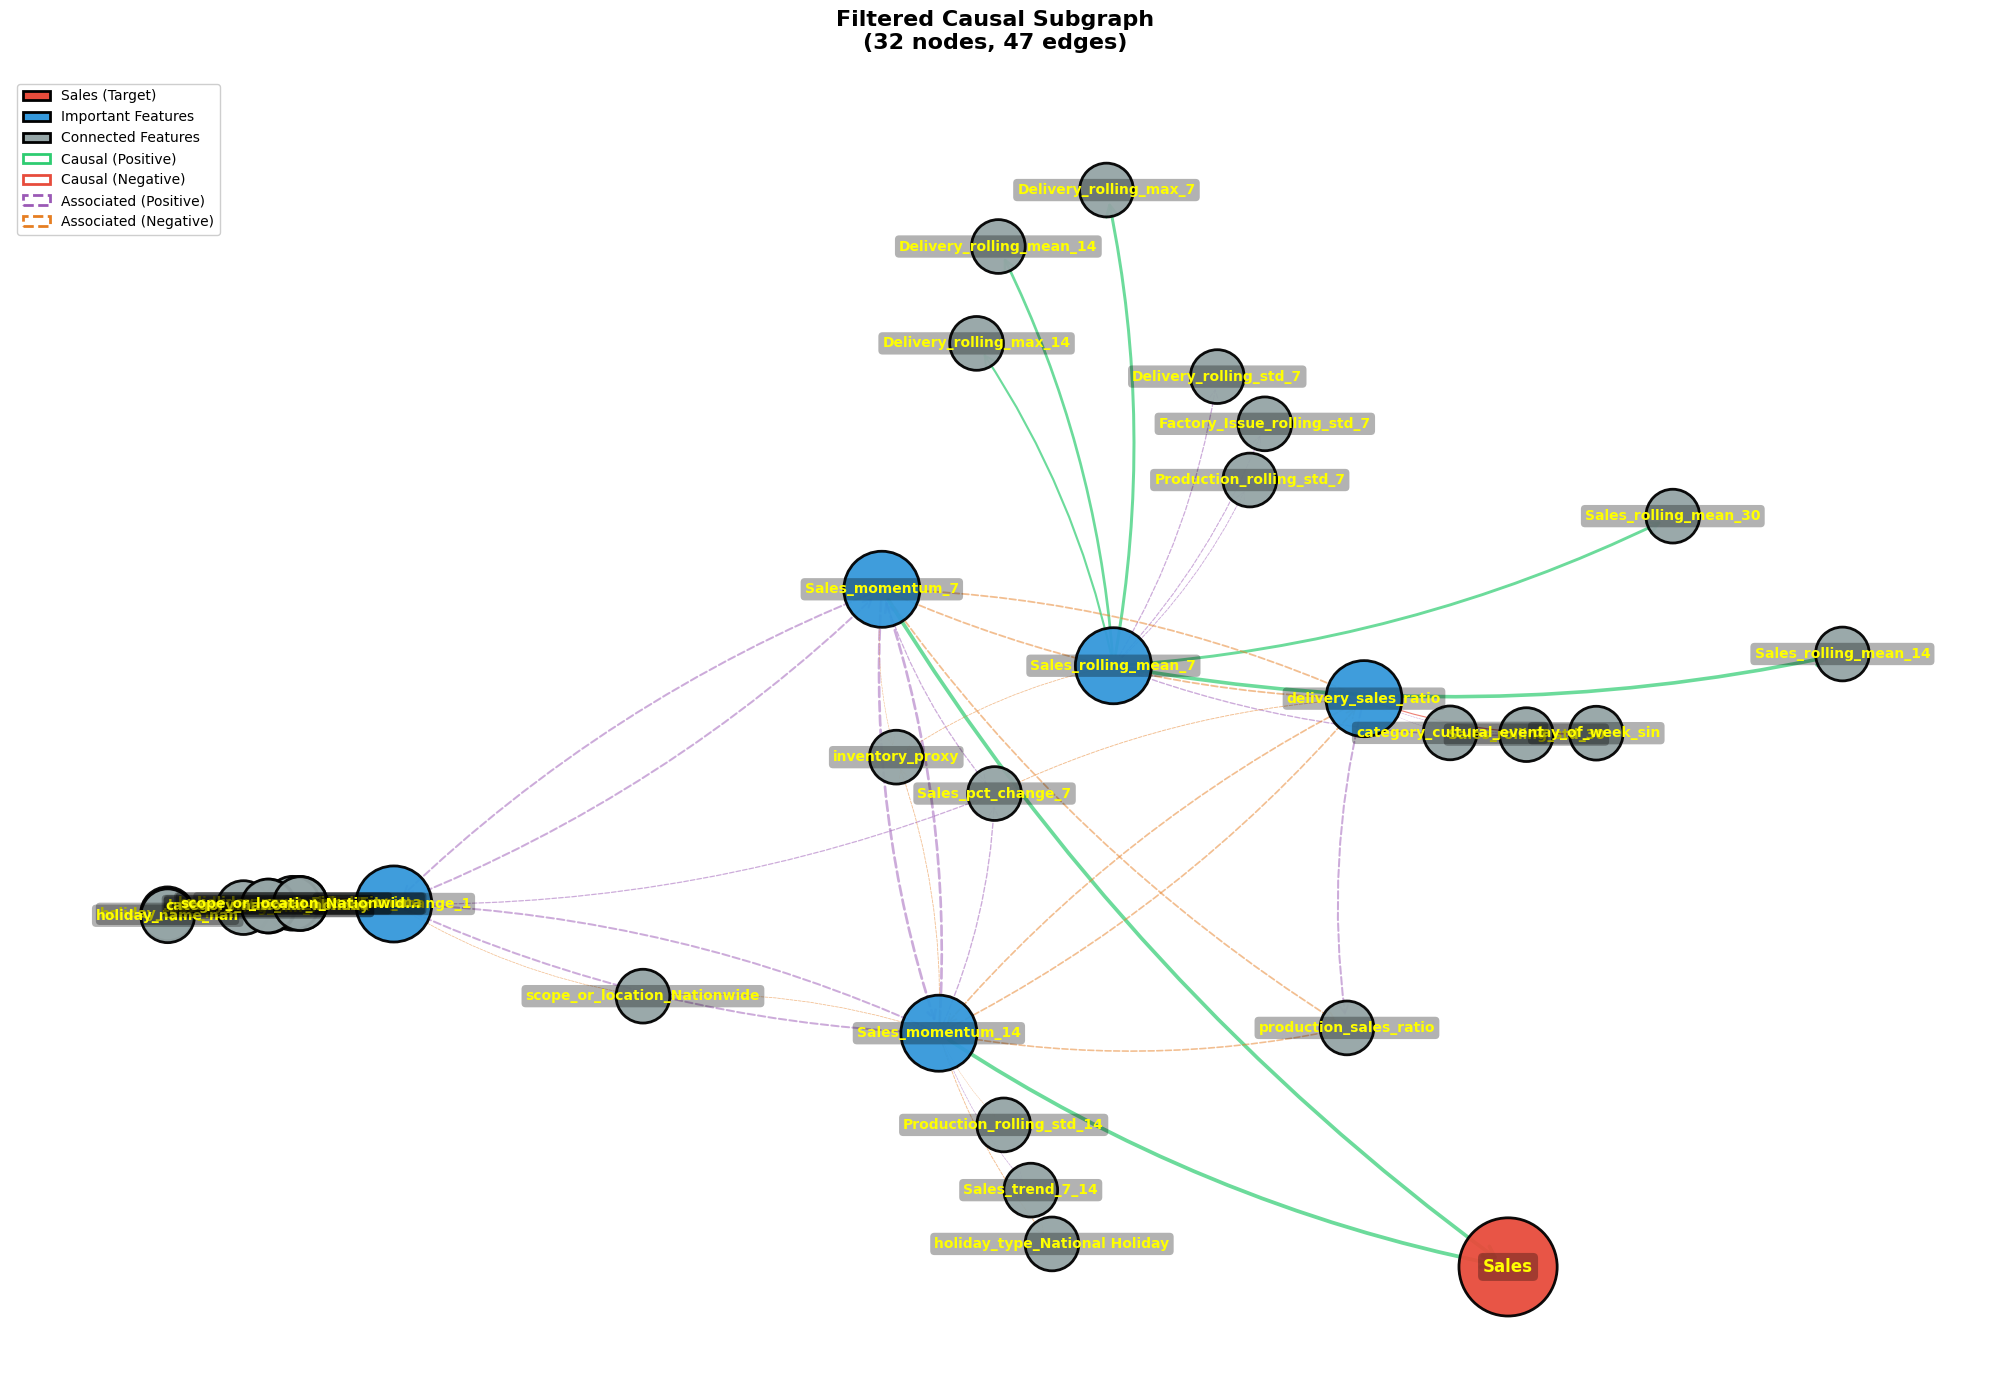

In [18]:
# Example with custom font size, font color, and node sizes
matching_edges_custom = extract_and_visualize_feature_subgraph(
    explanations_df=explanations,
    edges_df=edges_df,
    top_n=5,
    relationship_type='all',
    lag=None,
    coefficient_threshold=None,
    source_target= 'source', # 'all',
    output_path='../causality/filtered_subgraph_custom_style.png',
    figsize=(20, 14),
    font_size=10,           # Larger font
    font_color='yellow',    # Yellow text
    node_size_sales=5000,   # Larger Sales node
    node_size_important=3000,  # Larger important nodes
    node_size_other=1500    # Larger other nodes
)

Searching for 3 important features
Features: ['Sales_pct_change_1', 'Sales_momentum_7', 'Sales_momentum_14']

✓ Filtered by SOURCE or TARGET: 71 edges
✓ Filtered by relationship_type='causal': 21 edges
✓ Filtered by lag in [0]: 21 edges
✓ Filtered by |coefficient| >= 0.5: 21 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 21
Unique source nodes: 10
Unique target nodes: 4

Relationship types:
relationship_type
causal    21
Name: count, dtype: int64

Lag distribution:
lag
0    21
Name: count, dtype: int64

Coefficient range: [1.0000, 1.0000]
Correlation range: [-0.4062, 0.9088]

✓ Visualization saved to: ../causality/filtered_subgraph_minimal.png


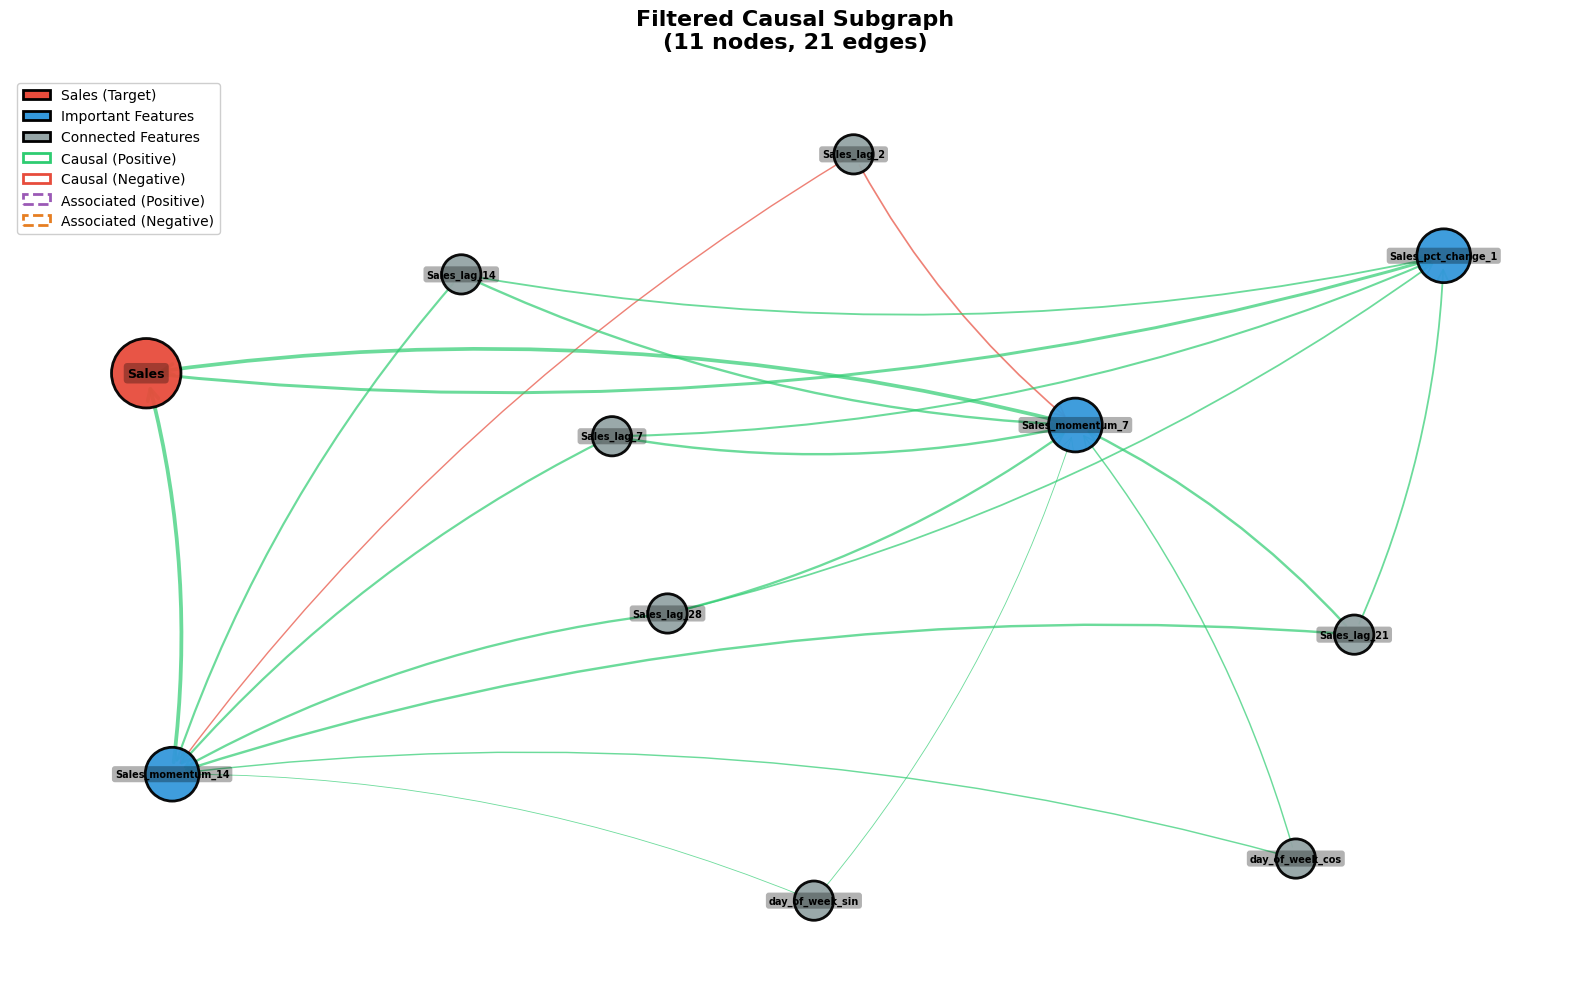

In [19]:
# Example with smaller nodes and black font
matching_edges_minimal = extract_and_visualize_feature_subgraph(
    explanations_df=explanations,
    edges_df=edges_df,
    top_n=3,
    relationship_type='causal',
    lag=[0],
    coefficient_threshold=0.5,
    source_target='all',
    output_path='../causality/filtered_subgraph_minimal.png',
    figsize=(16, 10),
    font_size=7,              # Smaller font
    font_color='black',       # Black text
    node_size_sales=2500,     # Smaller nodes
    node_size_important=1500,
    node_size_other=800
)

Searching for 2 important features
Features: ['Sales_momentum_7', 'Sales_momentum_14']

✓ Filtered by SOURCE or TARGET: 46 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 46
Unique source nodes: 18
Unique target nodes: 12

Relationship types:
relationship_type
associated    30
causal        16
Name: count, dtype: int64

Lag distribution:
lag
0    46
Name: count, dtype: int64

Coefficient range: [0.1514, 1.0000]
Correlation range: [-0.6446, 0.9703]

✓ Visualization saved to: ../causality/filtered_subgraph_presentation.png


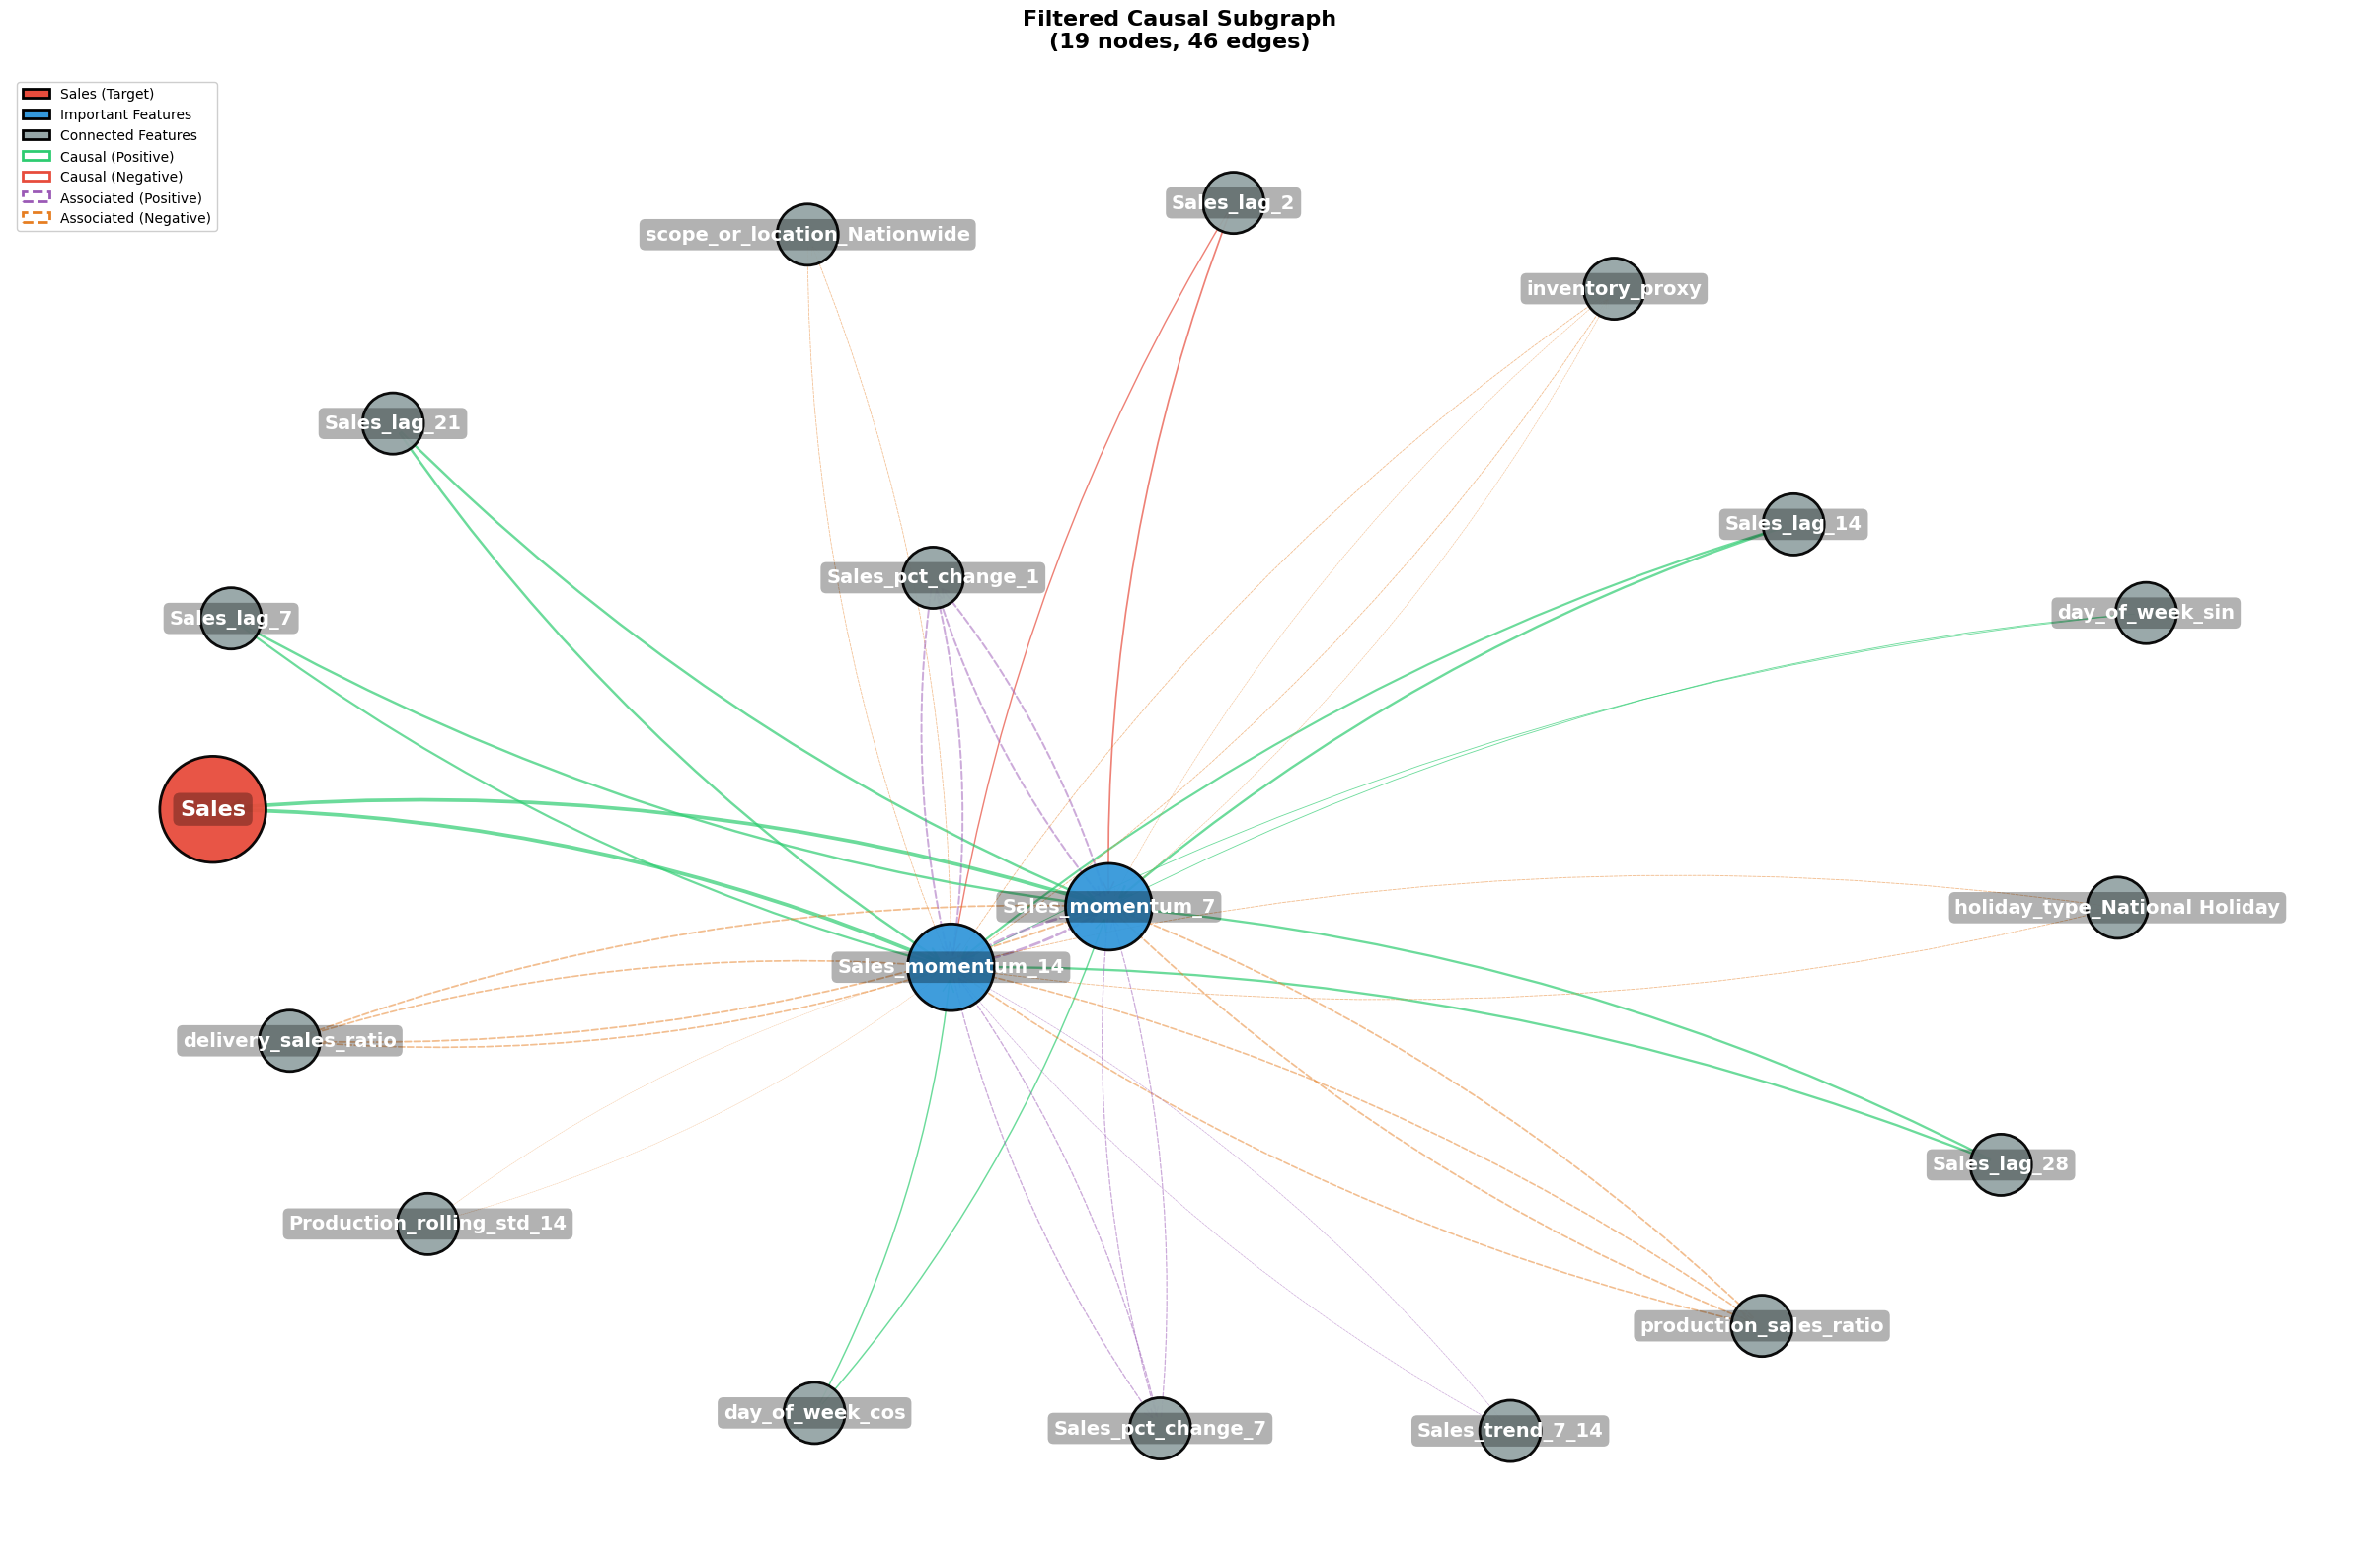

In [20]:
# Example with very large nodes and large font for presentation
matching_edges_presentation = extract_and_visualize_feature_subgraph(
    explanations_df=explanations.head(2),
    edges_df=edges_df,
    relationship_type='all',
    lag=None,
    coefficient_threshold=None,
    source_target='all',
    output_path='../causality/filtered_subgraph_presentation.png',
    figsize=(24, 16),
    font_size=14,             # Very large font for presentation
    font_color='white',       # White text
    node_size_sales=6000,     # Very large Sales node
    node_size_important=4000, # Large important nodes
    node_size_other=2000      # Medium other nodes
)

Searching for 5 important features
Features: ['Sales_rolling_mean_7', 'Sales_momentum_14', 'Sales_pct_change_1', 'Sales_momentum_7', 'delivery_sales_ratio']

✓ Filtered by SOURCE: 47 edges
✓ Filtered by relationship_type='causal': 8 edges
✓ Filtered by lag in [0]: 8 edges
✓ Filtered by |coefficient| >= 0.5: 8 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 8
Unique source nodes: 4
Unique target nodes: 7

Relationship types:
relationship_type
causal    8
Name: count, dtype: int64

Lag distribution:
lag
0    8
Name: count, dtype: int64

Coefficient range: [1.0000, 1.0000]
Correlation range: [-0.2733, 0.9088]

✓ Visualization saved to: ../causality/filtered_subgraph_source_causal.png


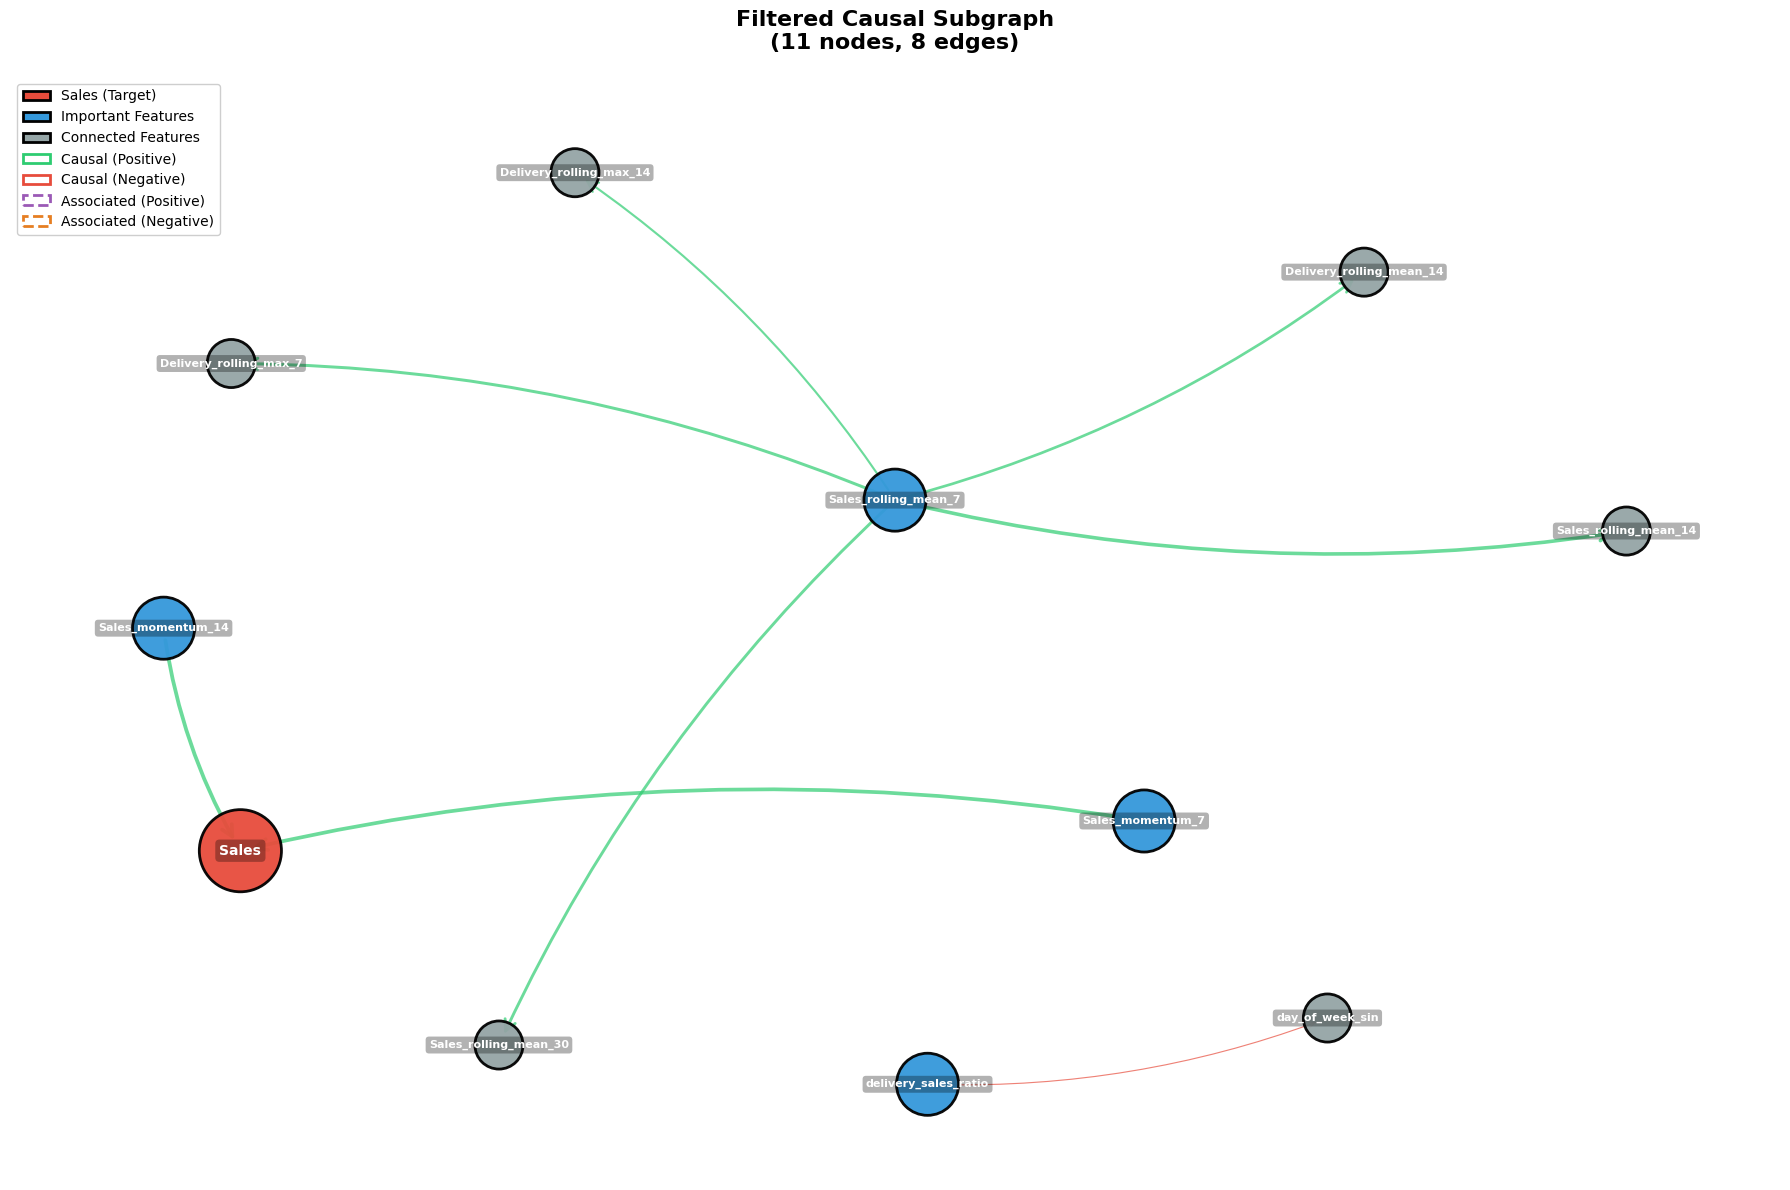

In [21]:
# Example 1: Get all edges where important features are in SOURCE, only causal relationships
matching_edges_1 = extract_and_visualize_feature_subgraph(
    explanations_df=explanations,
    edges_df=edges_df,
    top_n=5,  # Top 5 important features
    relationship_type='causal',  # Only causal relationships
    lag=[0],  # Only lag 0
    coefficient_threshold=0.5,  # Minimum coefficient of 0.5
    source_target='source',  # Look in source column only
    output_path='../causality/filtered_subgraph_source_causal.png'
)

Searching for 5 important features
Features: ['Sales_rolling_mean_7', 'Sales_momentum_14', 'Sales_pct_change_1', 'Sales_momentum_7', 'delivery_sales_ratio']

✓ Filtered by SOURCE or TARGET: 137 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 137
Unique source nodes: 65
Unique target nodes: 32

Relationship types:
relationship_type
causal        69
associated    68
Name: count, dtype: int64

Lag distribution:
lag
0    137
Name: count, dtype: int64

Coefficient range: [0.1093, 1.0000]
Correlation range: [-0.6446, 0.9703]

✓ Visualization saved to: ../causality/filtered_subgraph_all.png


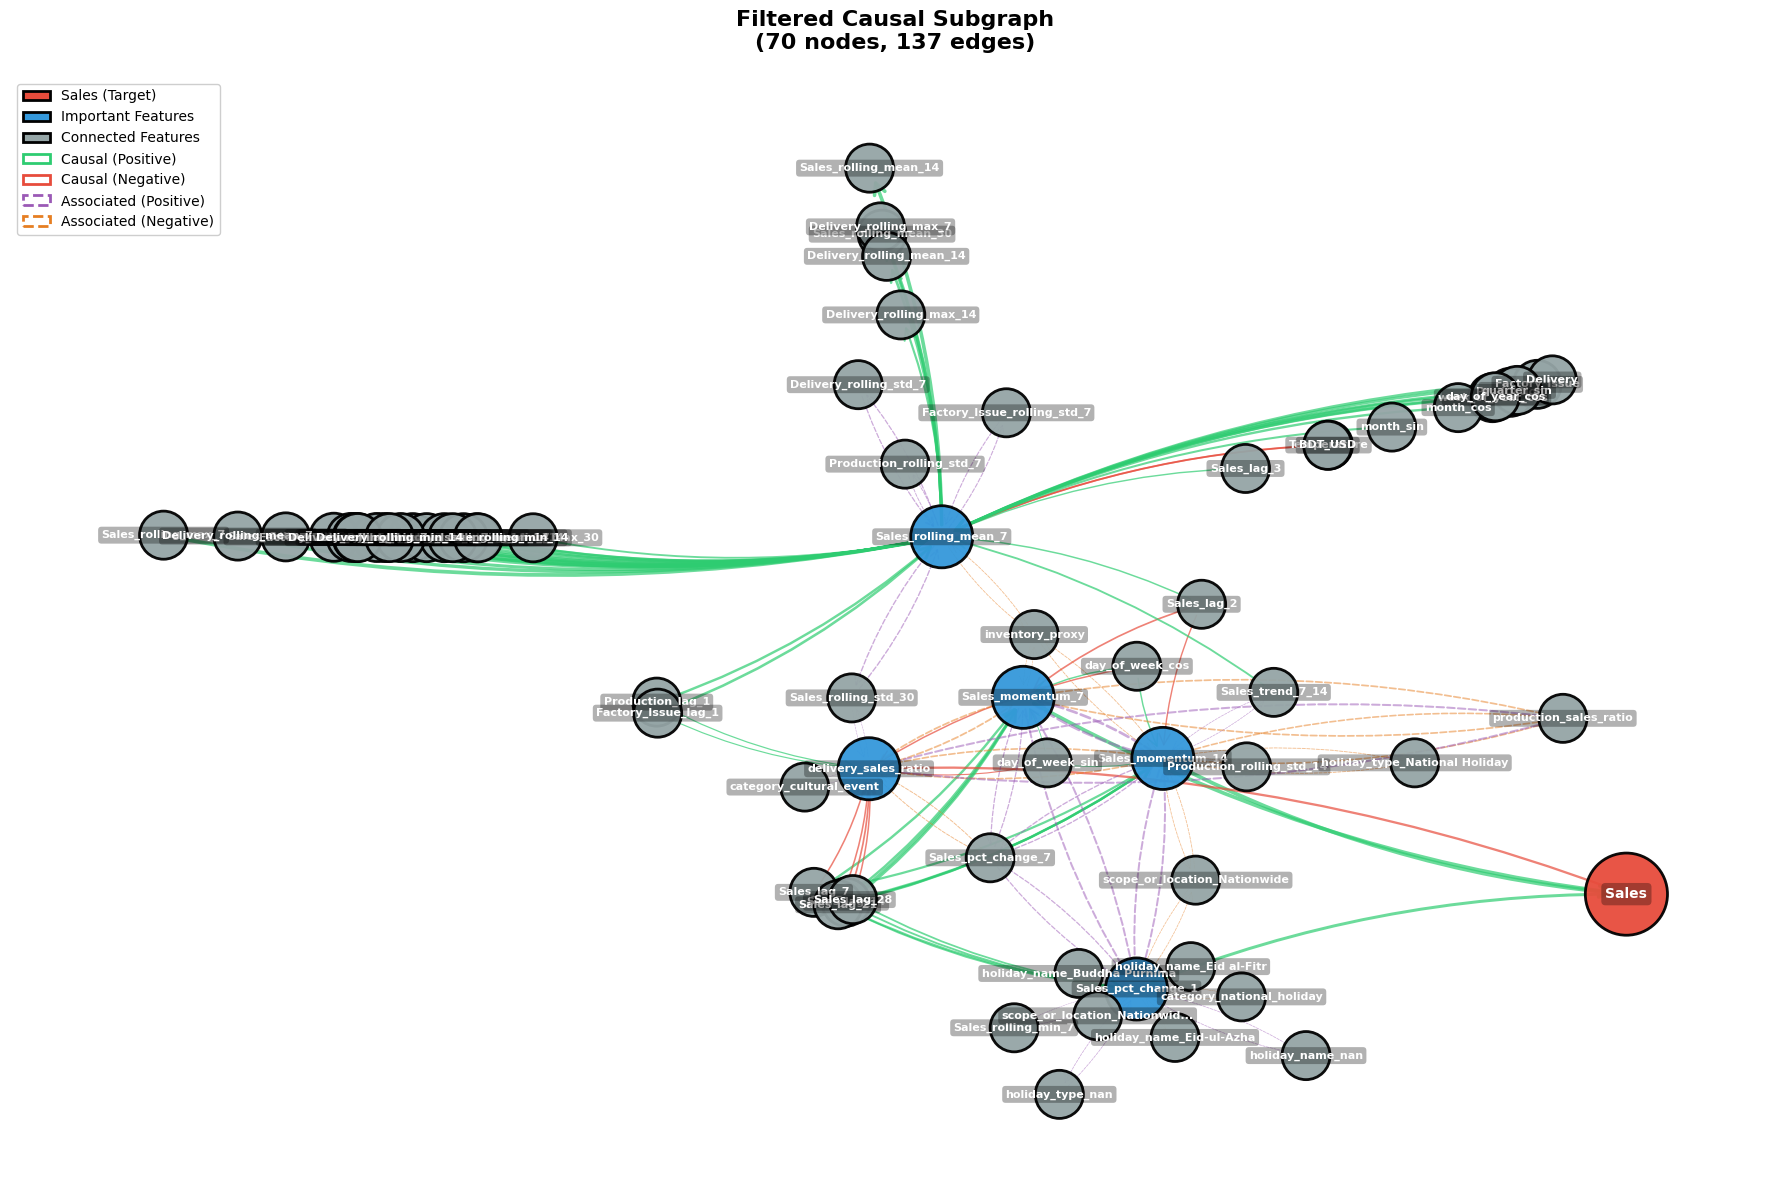

In [22]:
# Example 2: Get all edges (source or target) with all relationship types
matching_edges_2 = extract_and_visualize_feature_subgraph(
    explanations_df=explanations,
    edges_df=edges_df,
    top_n=5,
    relationship_type='all',  # All relationship types
    lag=None,  # All lags
    coefficient_threshold=None,  # All coefficients
    source_target='all',  # Look in both source and target
    output_path='../causality/filtered_subgraph_all.png'
)

Searching for 10 important features
Features: ['Sales_rolling_mean_7', 'Delivery_rolling_min_7', 'Sales_momentum_14', 'Delivery_rolling_std_14', 'Sales_pct_change_7', 'Sales_rolling_mean_14', 'Sales_pct_change_1', 'Sales_momentum_7', 'delivery_sales_ratio', 'Delivery_rolling_max_7']

✓ Filtered by TARGET: 248 edges
✓ Filtered by relationship_type='causal': 176 edges
✓ Filtered by lag in [0, 1]: 176 edges
✓ Filtered by |coefficient| >= 0.3: 176 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 176
Unique source nodes: 60
Unique target nodes: 10

Relationship types:
relationship_type
causal    176
Name: count, dtype: int64

Lag distribution:
lag
0    176
Name: count, dtype: int64

Coefficient range: [1.0000, 1.0000]
Correlation range: [-0.5874, 0.8940]

✓ Visualization saved to: ../causality/filtered_subgraph_target.png


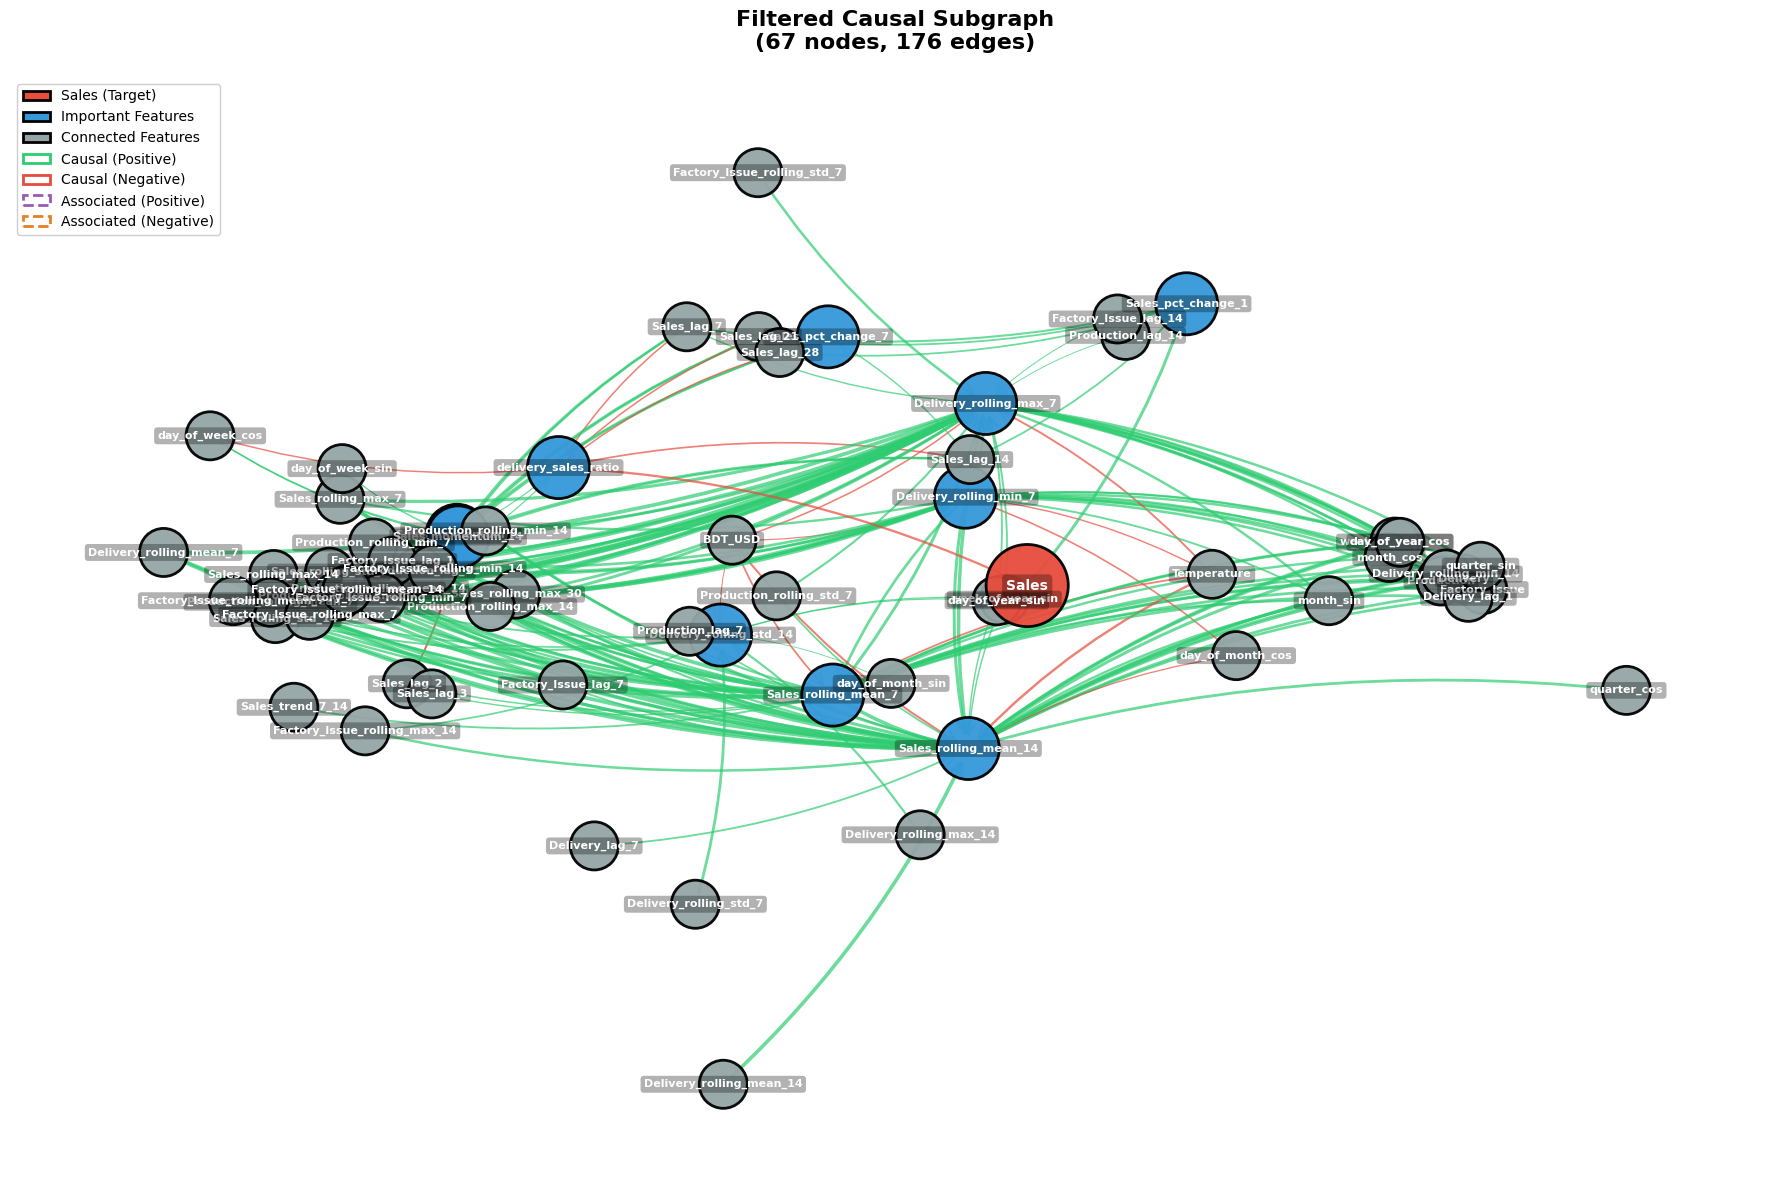

In [23]:
# Example 3: Get only TARGET edges (where important features are targets)
matching_edges_3 = extract_and_visualize_feature_subgraph(
    explanations_df=explanations,
    edges_df=edges_df,
    top_n=10,
    relationship_type='causal',
    lag=[0, 1],  # Lag 0 and 1
    coefficient_threshold=0.3,
    source_target='target',  # Look in target column only
    output_path='../causality/filtered_subgraph_target.png'
)

Searching for 1 important features
Features: ['Sales_momentum_14']

✓ Filtered by SOURCE or TARGET: 28 edges

FILTERED SUBGRAPH SUMMARY
Total edges: 28
Unique source nodes: 18
Unique target nodes: 12

Relationship types:
relationship_type
associated    20
causal         8
Name: count, dtype: int64

Lag distribution:
lag
0    28
Name: count, dtype: int64

Coefficient range: [0.1514, 1.0000]
Correlation range: [-0.6070, 0.9703]

✓ Visualization saved to: ../causality/filtered_subgraph_first_feature.png


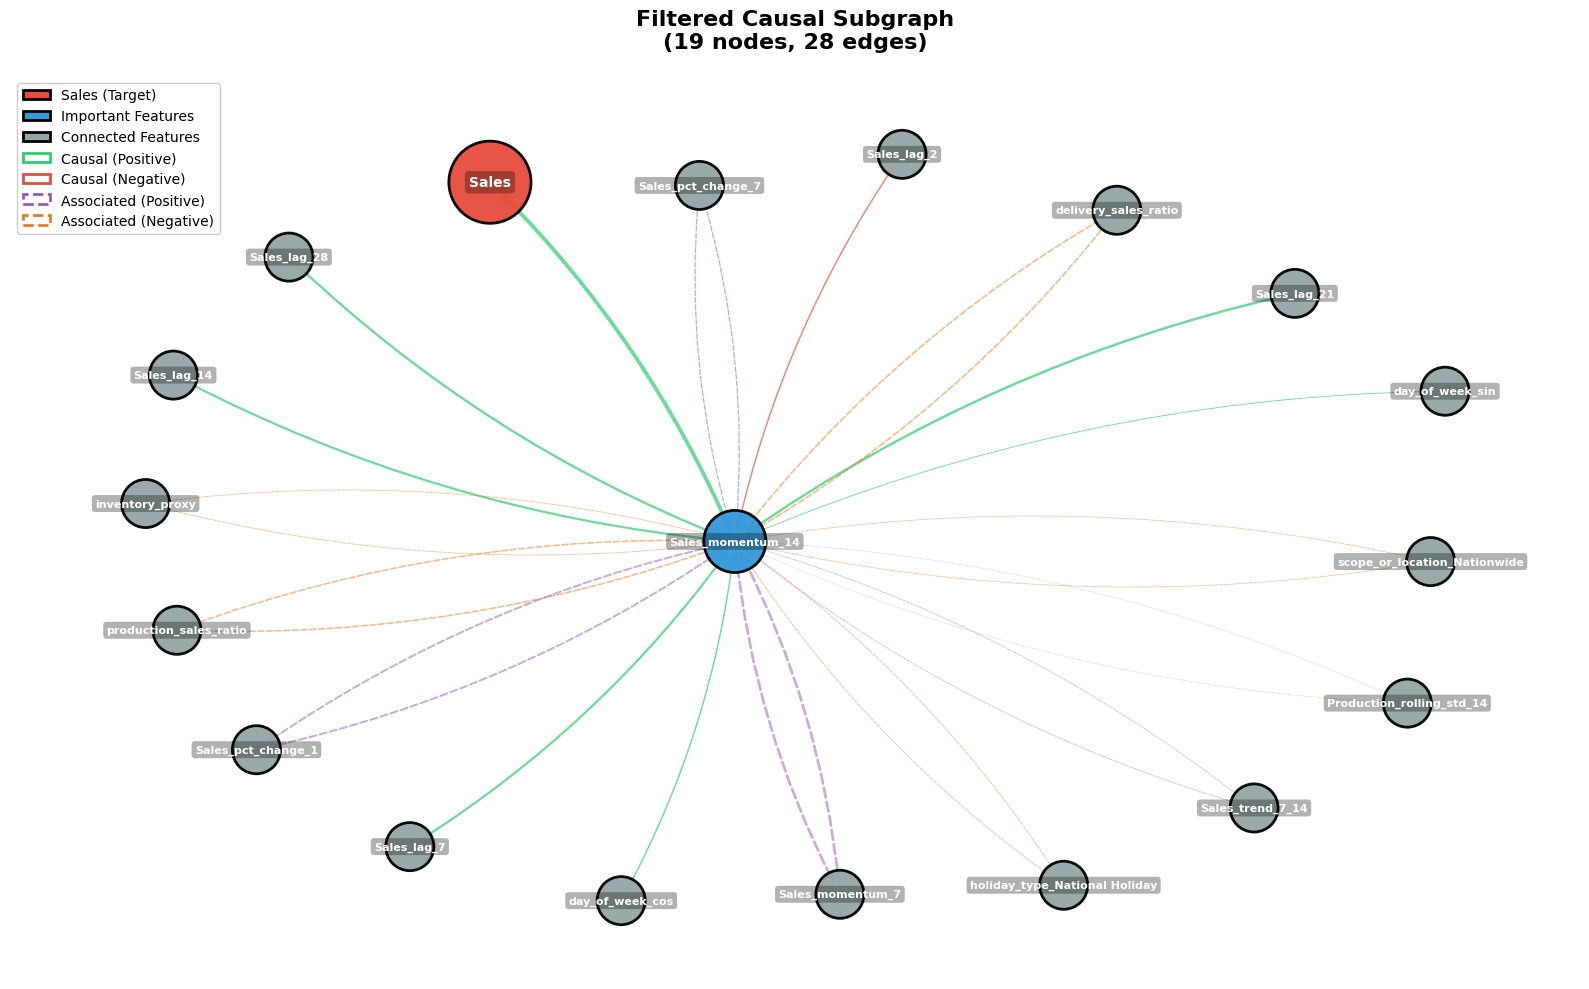

In [24]:
# Example 4: Simple case - just get edges for first feature
matching_edges_4 = extract_and_visualize_feature_subgraph(
    explanations_df=explanations.head(1),  # Just first feature
    edges_df=edges_df,
    relationship_type='all',
    lag=None,
    coefficient_threshold=None,
    source_target='all',
    output_path='../causality/filtered_subgraph_first_feature.png',
    figsize=(16, 10)
)

In [25]:
# Display the results
print("\nFiltered edges:")
display(matching_edges_4)


Filtered edges:


,id,source,source_index,target,target_index,coefficient,correlation,relationship_type,lag
208,208,Sales_lag_2,10,Sales_momentum_14,76,1.000000,-0.339907,causal,0
229,229,Sales_lag_7,12,Sales_momentum_14,76,1.000000,0.534789,causal,0
245,245,Sales_lag_14,13,Sales_momentum_14,76,1.000000,0.523404,causal,0
256,256,Sales_lag_21,14,Sales_momentum_14,76,1.000000,0.584845,causal,0
268,268,Sales_lag_28,15,Sales_momentum_14,76,1.000000,0.557753,causal,0
618,618,Production_rolling_std_14,40,Sales_momentum_14,76,0.151374,-0.151374,associated,0
1075,1075,Sales_pct_change_1,73,Sales_momentum_14,76,0.718027,0.718027,associated,0
1092,1092,Sales_pct_change_7,74,Sales_momentum_14,76,0.487183,0.487183,associated,0
1104,1104,Sales_momentum_7,75,Sales_momentum_14,76,0.970280,0.970280,associated,0
1109,1109,Sales_momentum_14,76,Production_rolling_std_14,40,0.151374,-0.151374,associated,0


In [26]:
edges_df

,id,source,source_index,target,target_index,coefficient,correlation,relationship_type,lag
0,0,Production,0,Factory_Issue,1,1.0,0.798509,causal,0
1,1,Production,0,Delivery,2,1.0,0.705910,causal,0
2,2,Production,0,Sales_rolling_mean_7,16,1.0,0.638204,causal,0
3,3,Production,0,Sales_rolling_std_7,17,1.0,0.507374,causal,0
4,4,Production,0,Sales_rolling_max_7,19,1.0,0.555231,causal,0
...,...,...,...,...,...,...,...,...,...
1774,1774,Sales,198,Sales_pct_change_1,73,1.0,0.715950,causal,0
1775,1775,Sales,198,day_of_week_sin,78,1.0,0.203358,causal,0
1776,1776,Sales,198,production_sales_ratio,100,1.0,-0.513331,causal,0
1777,1777,Sales,198,delivery_sales_ratio,101,1.0,-0.550902,causal,0


In [27]:
X_test

,Date,Production,Factory_Issue,Delivery,Rainfall,Sunshine,Humidity,Temperature,typical_rain_mm,BDT_USD,...,category_religious_period,category_school_university,category_weather_event,scope_or_location_Chattogram division & south-east,scope_or_location_Nationwide,scope_or_location_Nationwide (strongest in Buddhist communities),scope_or_location_Nationwide (strongest in cities),scope_or_location_Tongi near Dhaka,scope_or_location_Urban centres (esp. Dhaka),scope_or_location_nan
0,2023-07-11,0.053025,0.074017,0.057634,0.026087,0.000000,0.698413,0.821256,0.000000,0.897891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2023-07-12,0.053025,0.037468,0.025328,0.000000,0.009524,0.698413,0.811594,0.000000,0.706450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2023-07-13,0.042420,0.015803,0.027650,0.008696,0.371429,0.714286,0.816425,0.000000,0.866934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2023-07-14,0.042420,0.042463,0.029540,0.008696,0.038095,0.761905,0.801932,0.000000,0.863074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2023-07-15,0.018559,0.021155,0.032835,0.052174,0.600000,0.682540,0.787440,0.000000,0.830026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2023-08-05,0.063789,0.087118,0.079765,0.478261,0.542857,0.777778,0.777778,0.845333,0.774092,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1226,2023-08-06,0.053025,0.088444,0.063671,0.043478,0.476190,0.936508,0.700483,0.000000,0.791827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1227,2023-08-07,0.106050,0.085385,0.135335,0.156522,0.400000,1.000000,0.681159,0.000000,0.952885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1228,2023-08-08,0.054298,0.022684,0.027002,0.469565,0.676190,0.936508,0.676329,0.000000,0.969855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
explanations

,feature_name,feature_importance
0,Sales_momentum_14,-101.311963
1,Sales_momentum_7,-99.293675
2,Sales_pct_change_1,75.144040
3,Sales_rolling_mean_7,-71.304677
4,delivery_sales_ratio,59.740084
5,Sales_rolling_mean_14,-52.153070
6,Delivery_rolling_max_7,-42.031404
7,Sales_pct_change_7,41.036724
8,Delivery_rolling_std_14,-40.054289
9,Delivery_rolling_min_7,-35.654352


In [31]:
# pd.read_csv("../data/processed/df_merged.csv").columns.to_list()

main_features = [col for col in pd.read_csv("../data/processed/df_merged.csv").columns.to_list() if col not in ['Unnamed: 0', 'Date']]

In [32]:
main_features

['Product',
 'Sales',
 'Production',
 'Factory_Issue',
 'Delivery',
 'Group',
 'Sub-Group',
 'holiday_type',
 'holiday_name',
 'Station',
 'Rainfall',
 'Sunshine',
 'Humidity',
 'Temperature',
 'category',
 'scope_or_location',
 'typical_rain_mm',
 'BDT_USD']

In [33]:
import re

# List of base features (from df_merged.csv columns, excluding Date)
base_features = [
    'Product', 'Sales', 'Production', 'Factory_Issue', 'Delivery', 'Group', 'Sub-Group',
    'holiday_type', 'holiday_name', 'Station', 'Rainfall', 'Sunshine', 'Humidity', 
    'Temperature', 'category', 'scope_or_location', 'typical_rain_mm', 'BDT_USD'
]

# Also include lowercase variants if needed
base_features_lower = [f.lower() for f in base_features] + base_features

def get_base_feature(feature_name):
    """
    Extract the base feature from a derived feature name using pattern matching.
    For example: 'Sales_momentum_14' -> 'Sales'
    """
    # Split by common separators
    parts = re.split(r'[_]', feature_name)
    
    # Check each part
    for part in parts:
        if part in base_features or part.lower() in base_features_lower:
            return part
    
    # If no match, return the first part or the whole name
    return parts[0] if parts else feature_name

# Apply to explanations feature names
feature_base_mapping = {}
for feature in explanations['feature_name'].tolist():
    base = get_base_feature(feature)
    feature_base_mapping[feature] = base

# Display the mapping
for feature, base in list(feature_base_mapping.items())[:10]:  # Show first 10
    print(f"{feature} -> {base}")

Sales_momentum_14 -> Sales
Sales_momentum_7 -> Sales
Sales_pct_change_1 -> Sales
Sales_rolling_mean_7 -> Sales
delivery_sales_ratio -> delivery
Sales_rolling_mean_14 -> Sales
Delivery_rolling_max_7 -> Delivery
Sales_pct_change_7 -> Sales
Delivery_rolling_std_14 -> Delivery
Delivery_rolling_min_7 -> Delivery


---

In [34]:
"""
Robust Causal Discovery Using causal-learn Library
===================================================

This version handles multicollinearity by:
1. Removing highly correlated features
2. Using regularization
3. Selecting only variable features

Install: pip install causal-learn
"""

import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

try:
    from causallearn.search.ConstraintBased.PC import pc
    from causallearn.search.ScoreBased.GES import ges
    CAUSAL_LEARN_AVAILABLE = True
except ImportError:
    print("causal-learn not installed. Install with: pip install causal-learn")
    CAUSAL_LEARN_AVAILABLE = False


def remove_multicollinearity(df: pd.DataFrame, threshold: float = 0.95) -> pd.DataFrame:
    """
    Remove highly correlated features to avoid singular matrix issues.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    threshold : float
        Correlation threshold above which to remove features
        
    Returns:
    --------
    pd.DataFrame
        Dataframe with multicollinearity removed
    """
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Removing {len(to_drop)} highly correlated features (threshold={threshold})")
    
    return df.drop(columns=to_drop)


def load_and_preprocess_robust(filepath: str, 
                                date_col: str = 'Date',
                                target_col: str = 'Sales',
                                corr_threshold: float = 0.95) -> tuple:
    """
    Load and preprocess data with multicollinearity handling.
    """
    df = pd.read_csv(filepath)
    
    # Remove unnamed index column
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # Aggregate by date
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        agg_dict = {col: 'mean' for col in numeric_cols}
        df = df.groupby(date_col).agg(agg_dict).reset_index()
        df = df.drop(columns=[date_col])
    
    # Remove constant/low variance columns
    print("Removing low variance features...")
    selector = VarianceThreshold(threshold=0.01)
    
    # Keep track of column names
    original_cols = df.columns.tolist()
    df_values = selector.fit_transform(df)
    selected_cols = [original_cols[i] for i in range(len(original_cols)) 
                     if selector.variances_[i] > 0.01]
    
    df = pd.DataFrame(df_values, columns=selected_cols)
    print(f"Features after variance filter: {len(selected_cols)}")
    
    # Ensure target is included
    if target_col not in df.columns:
        print(f"Warning: Target '{target_col}' was removed. Adding it back.")
        # Reload just the target
        original_df = pd.read_csv(filepath)
        if 'Unnamed: 0' in original_df.columns:
            original_df = original_df.drop(columns=['Unnamed: 0'])
        if date_col in original_df.columns:
            original_df[date_col] = pd.to_datetime(original_df[date_col])
            original_df = original_df.groupby(date_col)[target_col].mean().reset_index()
            df[target_col] = original_df[target_col].values
    
    # Remove multicollinearity
    print("Removing multicollinear features...")
    df = remove_multicollinearity(df, threshold=corr_threshold)
    
    # Handle missing/infinite values
    df = df.fillna(0).replace([np.inf, -np.inf], 0)
    
    feature_names = df.columns.tolist()
    
    return df, feature_names


def run_pc_algorithm_robust(data: np.ndarray, 
                            feature_names: list, 
                            alpha: float = 0.05):
    """
    Run PC Algorithm with error handling.
    """
    print(f"\nRunning PC Algorithm...")
    print(f"Data shape: {data.shape}")
    print(f"Alpha: {alpha}")
    
    try:
        cg = pc(
            data=data,
            alpha=alpha,
            indep_test='fisherz',
            stable=True,
            uc_rule=0,
            uc_priority=2,
            show_progress=True
        )
        return cg, 'PC'
    except Exception as e:
        print(f"PC with fisherz failed: {e}")
        print("Trying GES (score-based method)...")
        
        try:
            # Try GES as fallback
            record = ges(data)
            return record, 'GES'
        except Exception as e2:
            print(f"GES also failed: {e2}")
            return None, None


def extract_edges(result, method: str, feature_names: list, data: np.ndarray) -> list:
    """
    Extract edges from causal-learn result.
    """
    edges = []
    n = len(feature_names)
    
    # Calculate correlations for edge strength
    corr_matrix = np.corrcoef(data.T)
    
    if method == 'PC':
        # Get the graph - it's a GeneralGraph object
        G = result.G
        
        # Get adjacency matrix from the graph
        adj_matrix = G.graph  # This is the numpy array
        
        for i in range(n):
            for j in range(n):
                if i != j:
                    # In causal-learn: 
                    # adj_matrix[i,j] = -1 and adj_matrix[j,i] = 1 means i -> j
                    # adj_matrix[i,j] = -1 and adj_matrix[j,i] = -1 means i -- j (undirected)
                    if adj_matrix[i, j] == -1 and adj_matrix[j, i] == 1:
                        edges.append({
                            'source': feature_names[i],
                            'target': feature_names[j],
                            'source_index': i,
                            'target_index': j,
                            'correlation': float(corr_matrix[i, j]),
                            'edge_type': 'directed'
                        })
                    # Undirected: both -1
                    elif adj_matrix[i, j] == -1 and adj_matrix[j, i] == -1 and i < j:
                        edges.append({
                            'source': feature_names[i],
                            'target': feature_names[j],
                            'source_index': i,
                            'target_index': j,
                            'correlation': float(corr_matrix[i, j]),
                            'edge_type': 'undirected'
                        })
    
    elif method == 'GES':
        G = result['G'].graph
        for i in range(n):
            for j in range(n):
                if i != j and G[i, j] != 0:
                    edges.append({
                        'source': feature_names[i],
                        'target': feature_names[j],
                        'source_index': i,
                        'target_index': j,
                        'correlation': float(corr_matrix[i, j]),
                        'edge_type': 'directed' if G[j, i] == 0 else 'undirected'
                    })
    
    return edges


def run_causal_discovery(
    filepath: str,
    target_col: str = 'Sales',
    alpha: float = 0.05,
    corr_threshold: float = 0.90,
    output_json: str = 'causal_graph_causallearn.json'
):
    """
    Main function for causal discovery using causal-learn.
    """
    if not CAUSAL_LEARN_AVAILABLE:
        print("Please install causal-learn: pip install causal-learn")
        return None
    
    print("="*70)
    print("CAUSAL DISCOVERY USING CAUSAL-LEARN LIBRARY")
    print("="*70)
    
    # Load and preprocess
    df, feature_names = load_and_preprocess_robust(
        filepath, 
        target_col=target_col,
        corr_threshold=corr_threshold
    )
    
    print(f"\nFinal feature count: {len(feature_names)}")
    print(f"Sample count: {len(df)}")
    
    # Standardize
    data = StandardScaler().fit_transform(df.values.astype(np.float64))
    
    # Add small noise to handle exact collinearity
    data = data + np.random.normal(0, 1e-6, data.shape)
    
    # Run causal discovery
    result, method = run_pc_algorithm_robust(data, feature_names, alpha)
    
    if result is None:
        print("All methods failed. Data may have severe multicollinearity.")
        return None
    
    print(f"\nSuccessfully ran: {method}")
    
    # Extract edges
    edges = extract_edges(result, method, feature_names, data)
    
    # Build output
    nodes = [{'id': i, 'name': name, 'index': i} for i, name in enumerate(feature_names)]
    
    graph = {
        'nodes': nodes,
        'edges': edges,
        'metadata': {
            'method': f'{method} Algorithm (causal-learn)',
            'library': 'causal-learn',
            'alpha': alpha,
            'correlation_threshold': corr_threshold,
            'n_features': len(feature_names),
            'n_edges': len(edges)
        }
    }
    
    # Save
    with open(output_json, 'w', encoding='utf-8') as f:
        json.dump(graph, f, indent=2)
    
    print(f"\nSaved to: {output_json}")
    
    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Method used: {method}")
    print(f"Total nodes: {len(nodes)}")
    print(f"Total edges: {len(edges)}")
    
    # Edges related to target
    target_causes = [e for e in edges if e['target'] == target_col]
    target_effects = [e for e in edges if e['source'] == target_col]
    
    print(f"\nCauses of {target_col} ({len(target_causes)}):")
    for e in sorted(target_causes, key=lambda x: abs(x['correlation']), reverse=True)[:10]:
        print(f"  {e['source']:40} -> {target_col}  (corr: {e['correlation']:.4f})")
    
    print(f"\nEffects of {target_col} ({len(target_effects)}):")
    for e in sorted(target_effects, key=lambda x: abs(x['correlation']), reverse=True)[:10]:
        print(f"  {target_col} -> {e['target']:40}  (corr: {e['correlation']:.4f})")
    
    return graph




In [35]:
graph = run_causal_discovery(
    filepath='df.csv',
    target_col='Sales',
    alpha=0.05,
    corr_threshold=0.90,
    output_json='../causality/causal_learn_module/causal_graph_causallearn.json'
)

CAUSAL DISCOVERY USING CAUSAL-LEARN LIBRARY
Removing low variance features...
Features after variance filter: 30
Removing multicollinear features...
Removing 7 highly correlated features (threshold=0.9)

Final feature count: 23
Sample count: 221

Running PC Algorithm...
Data shape: (221, 23)
Alpha: 0.05


Depth=4, working on node 22: 100%|██████████| 23/23 [00:00<00:00, 1946.94it/s]



Successfully ran: PC

Saved to: ../causality/causal_learn_module/causal_graph_causallearn.json

SUMMARY
Method used: PC
Total nodes: 23
Total edges: 28

Causes of Sales (2):
  day_of_week_cos                          -> Sales  (corr: 0.3623)
  day_of_week_sin                          -> Sales  (corr: 0.2059)

Effects of Sales (0):


In [36]:
graph

{'nodes': [{'id': 0, 'name': 'Rainfall', 'index': 0},
  {'id': 1, 'name': 'Sunshine', 'index': 1},
  {'id': 2, 'name': 'Humidity', 'index': 2},
  {'id': 3, 'name': 'Temperature', 'index': 3},
  {'id': 4, 'name': 'typical_rain_mm', 'index': 4},
  {'id': 5, 'name': 'BDT_USD', 'index': 5},
  {'id': 6, 'name': 'day_of_week_sin', 'index': 6},
  {'id': 7, 'name': 'day_of_week_cos', 'index': 7},
  {'id': 8, 'name': 'day_of_month_sin', 'index': 8},
  {'id': 9, 'name': 'day_of_month_cos', 'index': 9},
  {'id': 10, 'name': 'week_of_year_sin', 'index': 10},
  {'id': 11, 'name': 'week_of_year_cos', 'index': 11},
  {'id': 12, 'name': 'quarter_sin', 'index': 12},
  {'id': 13, 'name': 'quarter_cos', 'index': 13},
  {'id': 14, 'name': 'holiday_type_National Holiday', 'index': 14},
  {'id': 15, 'name': 'holiday_name_Eid al-Fitr', 'index': 15},
  {'id': 16, 'name': 'holiday_name_Eid-ul-Azha', 'index': 16},
  {'id': 17, 'name': 'category_cultural_event', 'index': 17},
  {'id': 18, 'name': 'category_natio